In [1]:
# data_preparation_fetal.py
import pandas as pd
from sklearn.model_selection import train_test_split
import os

DATASET_CSV = 'fetal_health.csv'
TRAIN_OUTPUT_CSV = 'fetal_train_features.csv'
TEST_OUTPUT_CSV = 'fetal_test_features.csv'
TEST_SIZE = 0.2
RANDOM_STATE = 42

CLASS_MAPPING = {1.0: 0, 2.0: 1, 3.0: 2}
CLASS_LABELS_STR = {0: 'Normal', 1: 'Suspect', 2: 'Pathological'}

def preprocess_and_split_data(csv_path, train_out_path, test_out_path, test_size, random_state):
    """
    Loads the Fetal Health CSV, preprocesses target, splits, and saves.
    """
    print(f"Loading dataset from: {csv_path}")
    if not os.path.exists(csv_path):
        print(f"ERROR: Dataset file '{csv_path}' not found.")
        print("Please download 'fetal_health.csv' and place it in the current directory.")
        return

    df = pd.read_csv(csv_path)
    print(f"Dataset loaded. Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nDataset info:")
    df.info()
    print("\nMissing values per column:")
    print(df.isnull().sum())

    if 'fetal_health' not in df.columns:
        print("ERROR: 'fetal_health' column not found in the dataset.")
        return

    df['fetal_health_label'] = df['fetal_health'].map(CLASS_MAPPING)

    print("\nTarget variable 'fetal_health' unique values (original):")
    print(df['fetal_health'].value_counts(dropna=False))
    print("\nTarget variable 'fetal_health_label' unique values (mapped to 0,1,2):")
    print(df['fetal_health_label'].value_counts(dropna=False))

    if df['fetal_health_label'].isnull().any():
        print("WARNING: Some 'fetal_health' values could not be mapped. Check CLASS_MAPPING.")

    feature_columns = [col for col in df.columns if col not in ['fetal_health', 'fetal_health_label']]
    X = df[feature_columns]
    y = df['fetal_health_label']

    print(f"\nNumber of features: {len(feature_columns)}")
    print(f"Feature columns: {feature_columns}")

    print(f"\nSplitting data: {1-test_size:.0%} train, {test_size:.0%} test...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

    train_df_to_save = X_train.copy()
    train_df_to_save['class'] = y_train.map(CLASS_LABELS_STR)

    test_df_to_save = X_test.copy()
    test_df_to_save['class'] = y_test.map(CLASS_LABELS_STR)

    train_df_to_save.to_csv(train_out_path, index=False)
    print(f"\nTraining data saved to: {train_out_path}")
    test_df_to_save.to_csv(test_out_path, index=False)
    print(f"Testing data saved to: {test_out_path}")

if __name__ == "__main__":
    preprocess_and_split_data(DATASET_CSV, TRAIN_OUTPUT_CSV, TEST_OUTPUT_CSV, TEST_SIZE, RANDOM_STATE)

Loading dataset from: fetal_health.csv
Dataset loaded. Shape: (2126, 22)

First 5 rows:
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term

In [2]:
!pip install shap

In [3]:
# classification_fetal.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.multiclass import OneVsRestClassifier

In [4]:

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [5]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [6]:
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP library not found. SHAP plots will be disabled. Install with: pip install shap")
    SHAP_AVAILABLE = False

In [7]:
CLASS_NAMES = ['Normal', 'Suspect', 'Pathological']
CLASS_IDX = [0, 1, 2]


In [8]:
def load_and_prepare_data(train_csv, test_csv):
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)
    feature_cols = [col for col in train_df.columns if col != 'class']
    X_train = train_df[feature_cols].values
    X_test = test_df[feature_cols].values
    le = LabelEncoder()
    le.fit(CLASS_NAMES)
    y_train = le.transform(train_df['class'])
    y_test = le.transform(test_df['class'])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test, feature_cols, le, scaler

In [9]:
def plot_learning_curve_custom(estimator, title, X, y, cv=5, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Score (Accuracy)")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

    plt.legend(loc="best")
    return plt




In [10]:
def plot_multi_class_pr_curve(clf_name, y_test, y_proba, label_encoder, n_classes):
    """Plots Precision-Recall curve for multi-class."""
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

    precision = dict()
    recall = dict()
    average_precision = dict()
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('viridis', n_classes + 2)

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_proba[:, i])
        plt.plot(recall[i], precision[i], color=colors(i), lw=2,
                 label=f'PR curve of class {label_encoder.classes_[i]} (AP = {average_precision[i]:.2f})')


    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
    average_precision["micro"] = average_precision_score(y_test_bin, y_proba, average="micro")
    plt.plot(recall["micro"], precision["micro"],
             label=f'Micro-average PR curve (AP = {average_precision["micro"]:.2f})',
             color=colors(n_classes), linestyle=':', linewidth=4)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Courbe Precision-Recall multi-classe - {clf_name}')
    plt.legend(loc="best")
    plt.savefig(f"pr_curve_fetal_{clf_name.replace(' ', '_').lower()}.png")
    plt.show()


In [11]:
def evaluate_classifier(clf, X_train, y_train, X_test, y_test, name, label_encoder, feature_names, scaler):
    print(f"\n--- Évaluation de {name} ---")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=label_encoder.transform(label_encoder.classes_))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matrice de confusion - {name}')
    plt.ylabel('Vraie classe'); plt.xlabel('Classe prédite')
    plt.tight_layout(); plt.savefig(f"confusion_matrix_fetal_{name.replace(' ', '_').lower()}.png"); plt.show()

    plot_learning_curve_custom(clf, f"Courbe d'apprentissage - {name}", X_train, y_train)
    plt.savefig(f"learning_curve_fetal_{name.replace(' ', '_').lower()}.png"); plt.show()

    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)
        n_classes = len(label_encoder.classes_)

        y_test_bin_roc = label_binarize(y_test, classes=list(range(n_classes)))
        fpr, tpr, roc_auc = dict(), dict(), dict()
        plt.figure(figsize=(10, 8))
        colors_roc = plt.cm.get_cmap('Set1', n_classes + 2)
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin_roc[:, i], y_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], color=colors_roc(i), lw=2,
                     label=f'ROC class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin_roc.ravel(), y_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-avg ROC (AUC = {roc_auc["micro"]:.2f})', color=colors_roc(n_classes), linestyle=':', lw=4)
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes): mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"], tpr["macro"], roc_auc["macro"] = all_fpr, mean_tpr, auc(all_fpr, mean_tpr)
        plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-avg ROC (AUC = {roc_auc["macro"]:.2f})', color=colors_roc(n_classes+1), linestyle=':', lw=4)

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel('Taux de faux positifs'); plt.ylabel('Taux de vrais positifs')
        plt.title(f'Courbe ROC multi-classe (OvR) - {name}'); plt.legend(loc="lower right")
        plt.savefig(f"roc_curve_fetal_{name.replace(' ', '_').lower()}.png"); plt.show()


        plot_multi_class_pr_curve(name, y_test, y_proba, label_encoder, n_classes)

        if SHAP_AVAILABLE:
            X_train_summary = shap.sample(X_train, 100) if X_train.shape[0] > 100 else X_train

            try:
                if isinstance(clf, (RandomForestClassifier, LogisticRegression)):
                    if isinstance(clf, RandomForestClassifier):
                        explainer = shap.TreeExplainer(clf)
                        shap_values = explainer.shap_values(X_test)
                    elif isinstance(clf, LogisticRegression):

                        masker = shap.maskers.Independent(X_train_summary)
                        explainer = shap.LinearExplainer(clf, masker)
                        shap_values = explainer.shap_values(X_test)

                    shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=label_encoder.classes_,
                                      plot_type="bar", show=False)
                    plt.title(f"SHAP Feature Importance - {name}")
                    plt.tight_layout()
                    plt.savefig(f"shap_summary_bar_{name.replace(' ', '_').lower()}.png")
                    plt.show()

                    for i, class_name_str in enumerate(label_encoder.classes_):
                        shap.summary_plot(shap_values[i], X_test, feature_names=feature_names, show=False)
                        plt.title(f"SHAP Values (Beeswarm) - {name} - Classe: {class_name_str}")
                        plt.tight_layout()
                        plt.savefig(f"shap_summary_beeswarm_{name.replace(' ', '_').lower()}_class_{class_name_str}.png")
                        plt.show()


            except Exception as e:
                print(f"  Could not generate SHAP plots for {name}: {e}")


    return {'name': name, 'accuracy': accuracy, 'precision_weighted': precision, 'recall_weighted': recall, 'f1_weighted': f1}

def plot_feature_importance_sklearn(X_train_df_cols, clf, title):
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        if clf.coef_.ndim > 1:
            importances = np.mean(np.abs(clf.coef_), axis=0)
        else:
            importances = np.abs(clf.coef_[0])
    else:
        return

    indices = np.argsort(importances)[::-1]
    num_features_to_plot = min(len(X_train_df_cols), 20)

    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.bar(range(num_features_to_plot), importances[indices][:num_features_to_plot], align='center', color='lightcoral')
    plt.xticks(range(num_features_to_plot), [X_train_df_cols[i] for i in indices[:num_features_to_plot]], rotation=90)
    plt.ylabel("Importance Score")
    plt.tight_layout()
    plt.savefig(f"feature_importance_sklearn_{title.replace(' ', '_').lower().replace('-', '_')}.png")
    plt.show()




--- Évaluation de SVM ---
Accuracy: 0.8944
Precision (weighted): 0.8884
Recall (weighted): 0.8944
F1-Score (weighted): 0.8901

Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.97      0.95       332
Pathological       0.86      0.71      0.78        35
     Suspect       0.67      0.58      0.62        59

    accuracy                           0.89       426
   macro avg       0.82      0.75      0.78       426
weighted avg       0.89      0.89      0.89       426



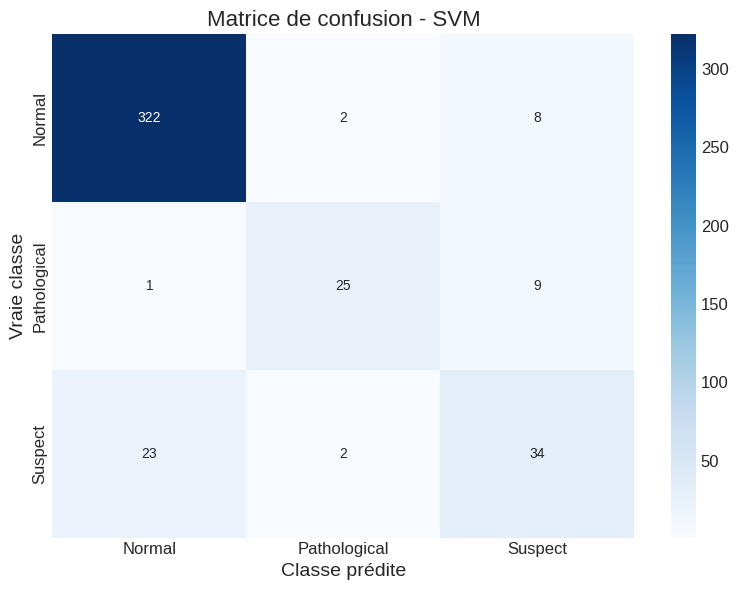

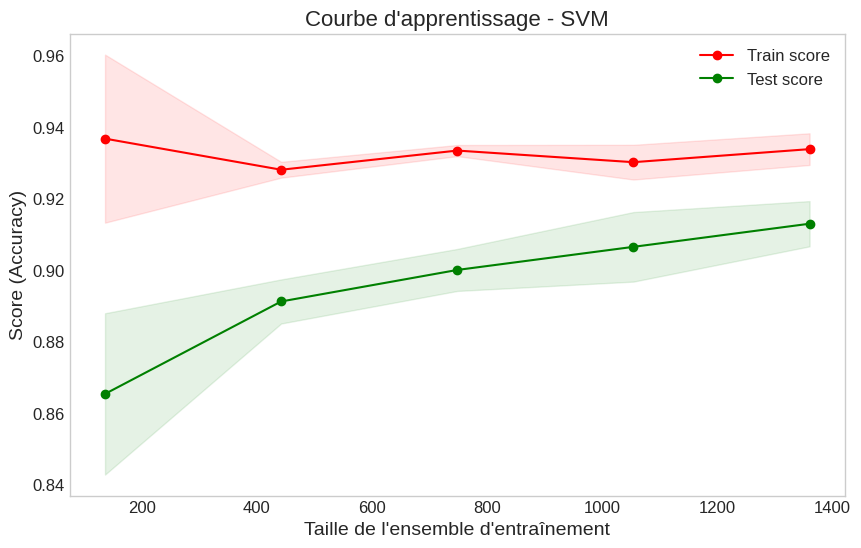

<ipython-input-11-828e36e0c252>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_roc = plt.cm.get_cmap('Set1', n_classes + 2)


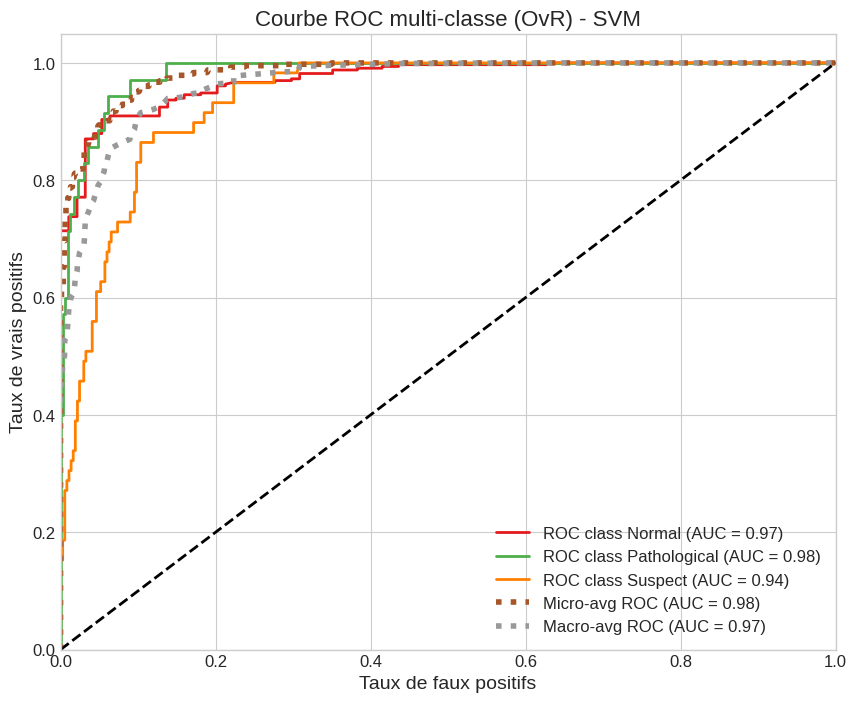

<ipython-input-10-2914cbfe6e4c>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes + 2)


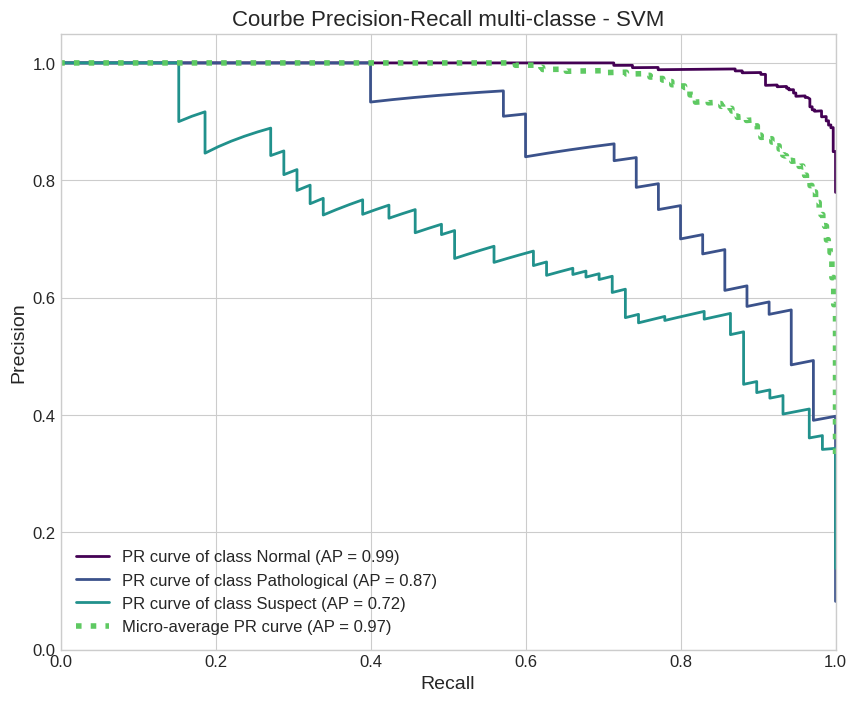


--- Évaluation de k-NN ---
Accuracy: 0.8709
Precision (weighted): 0.8623
Recall (weighted): 0.8709
F1-Score (weighted): 0.8624

Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.97      0.93       332
Pathological       0.92      0.63      0.75        35
     Suspect       0.61      0.47      0.53        59

    accuracy                           0.87       426
   macro avg       0.81      0.69      0.74       426
weighted avg       0.86      0.87      0.86       426



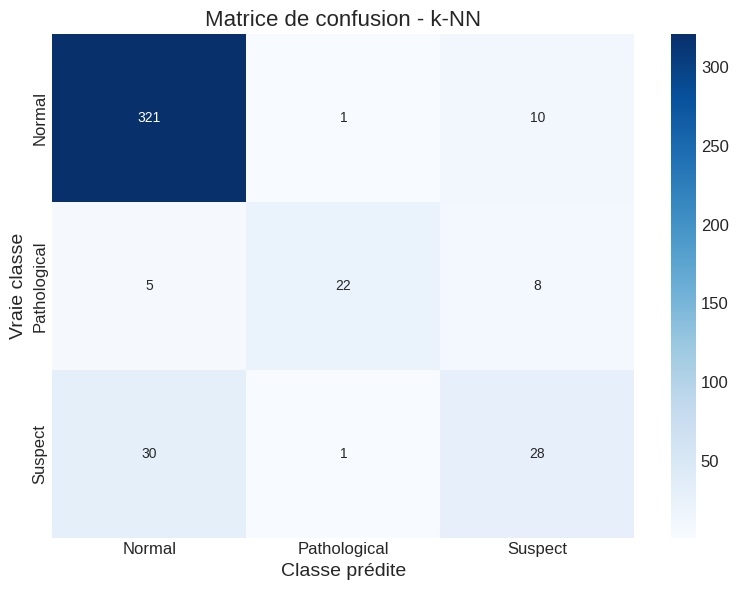

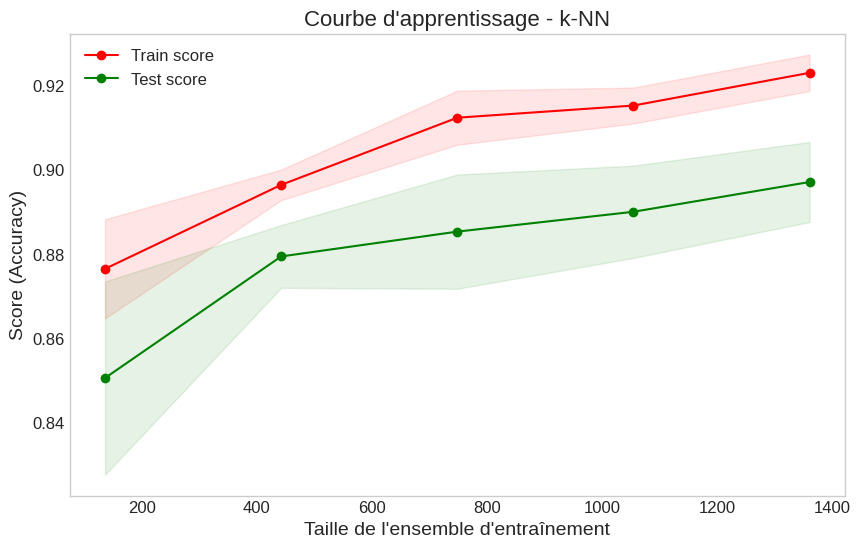

<ipython-input-11-828e36e0c252>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_roc = plt.cm.get_cmap('Set1', n_classes + 2)


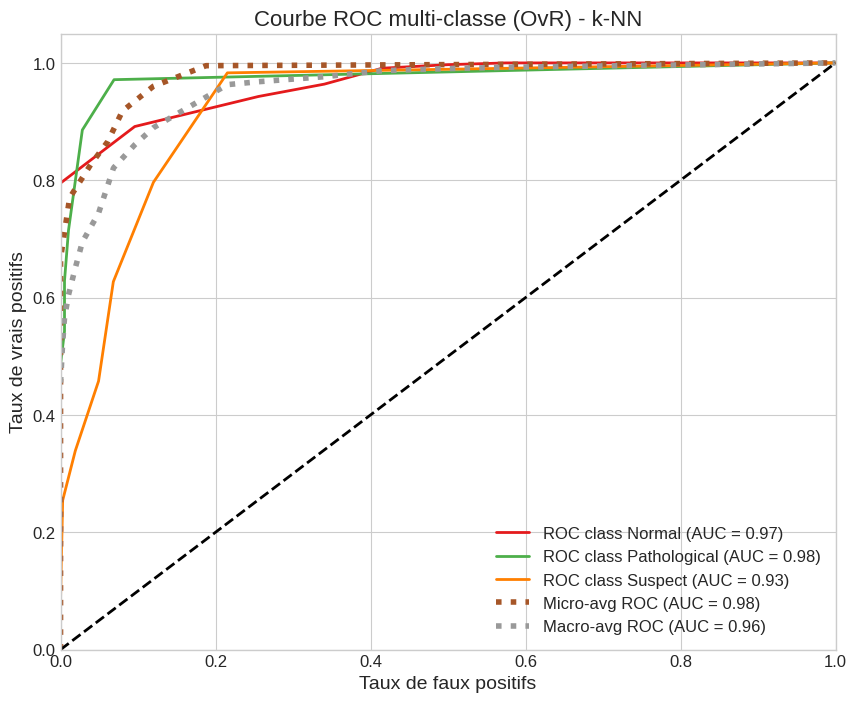

<ipython-input-10-2914cbfe6e4c>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes + 2)


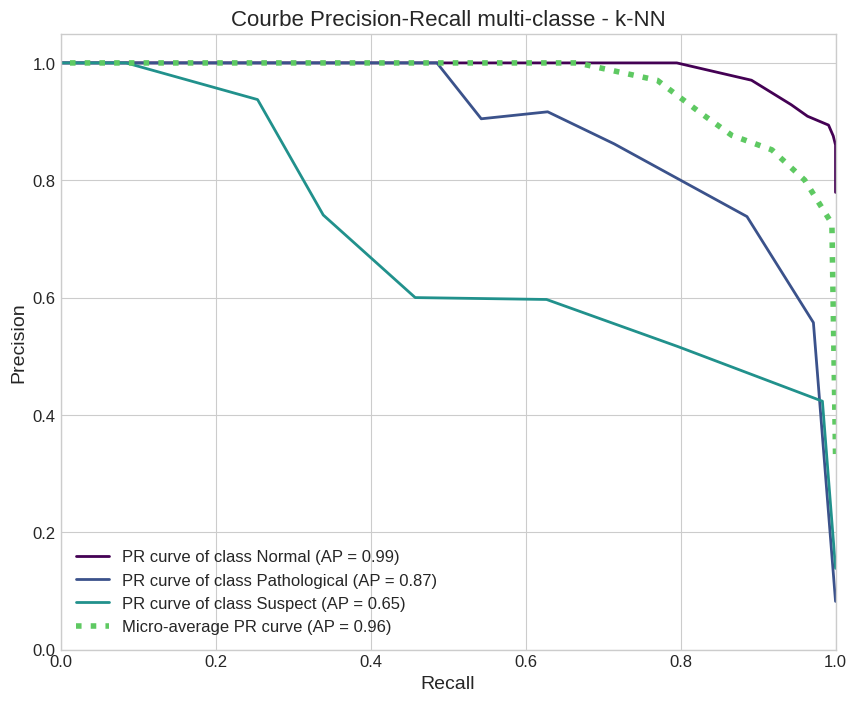


--- Évaluation de Random Forest ---
Accuracy: 0.9272
Precision (weighted): 0.9246
Recall (weighted): 0.9272
F1-Score (weighted): 0.9243

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96       332
Pathological       0.86      0.86      0.86        35
     Suspect       0.85      0.68      0.75        59

    accuracy                           0.93       426
   macro avg       0.88      0.84      0.86       426
weighted avg       0.92      0.93      0.92       426



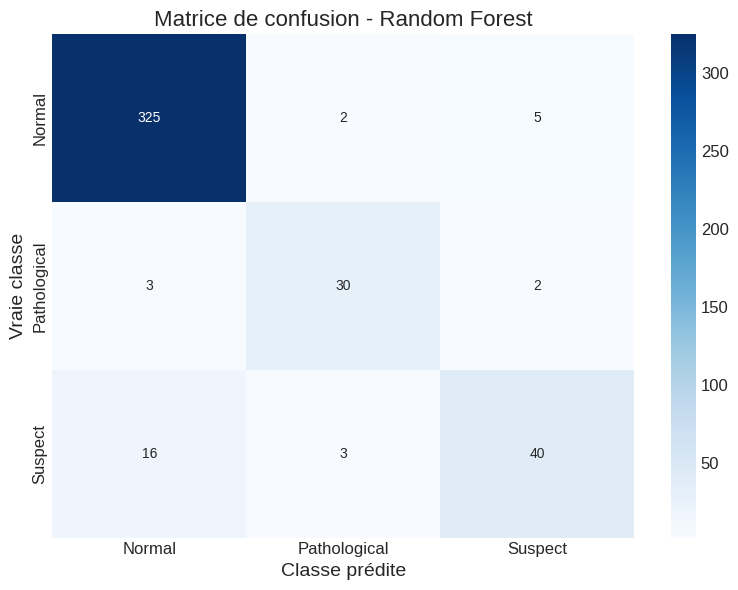

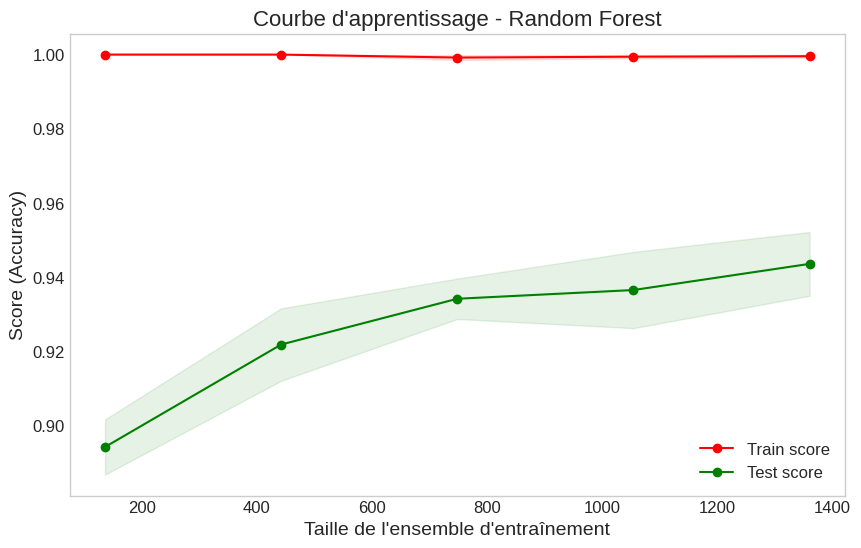

<ipython-input-11-828e36e0c252>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_roc = plt.cm.get_cmap('Set1', n_classes + 2)


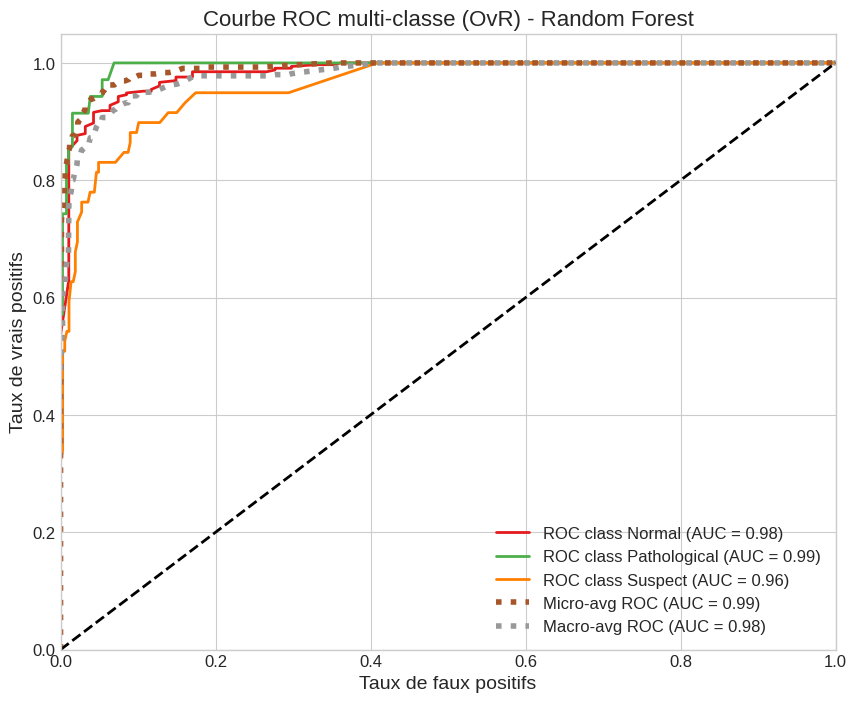

<ipython-input-10-2914cbfe6e4c>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes + 2)


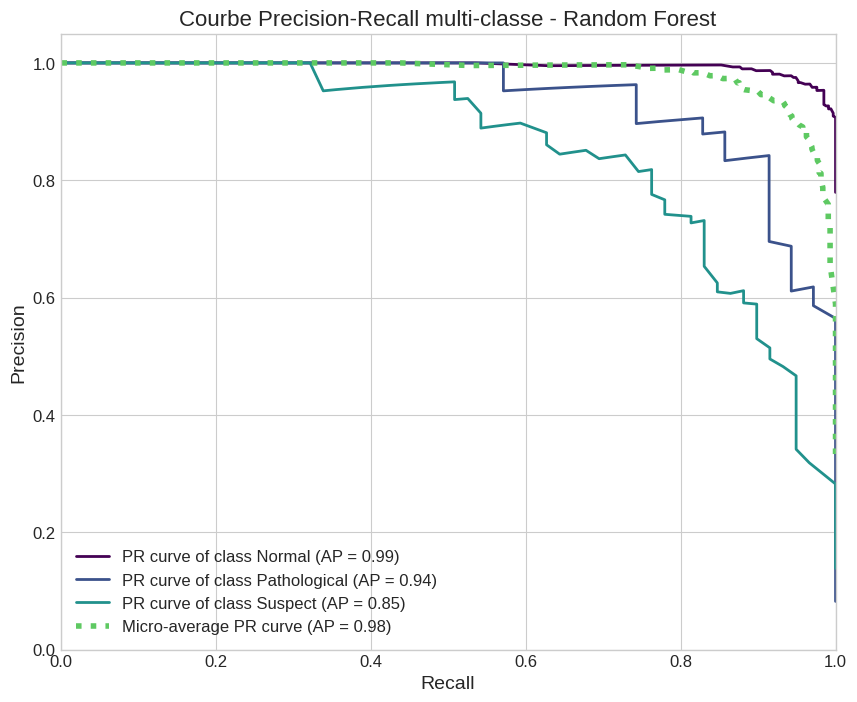

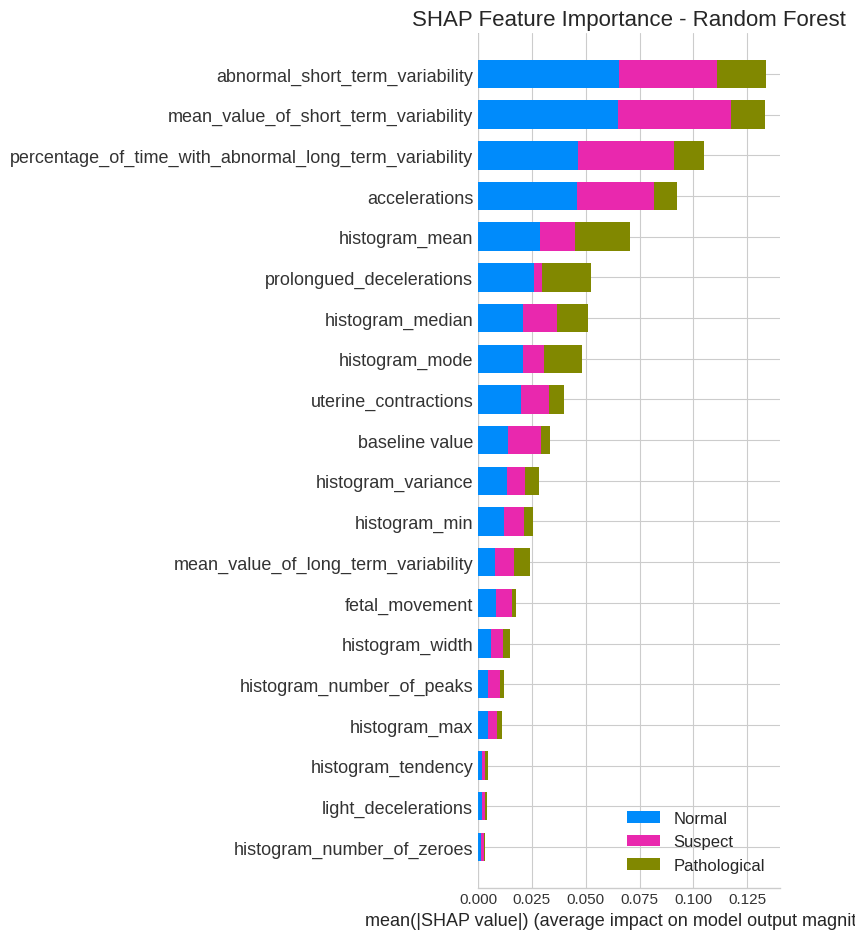

  Could not generate SHAP plots for Random Forest: The shape of the shap_values matrix does not match the shape of the provided data matrix.


<Figure size 1000x600 with 0 Axes>

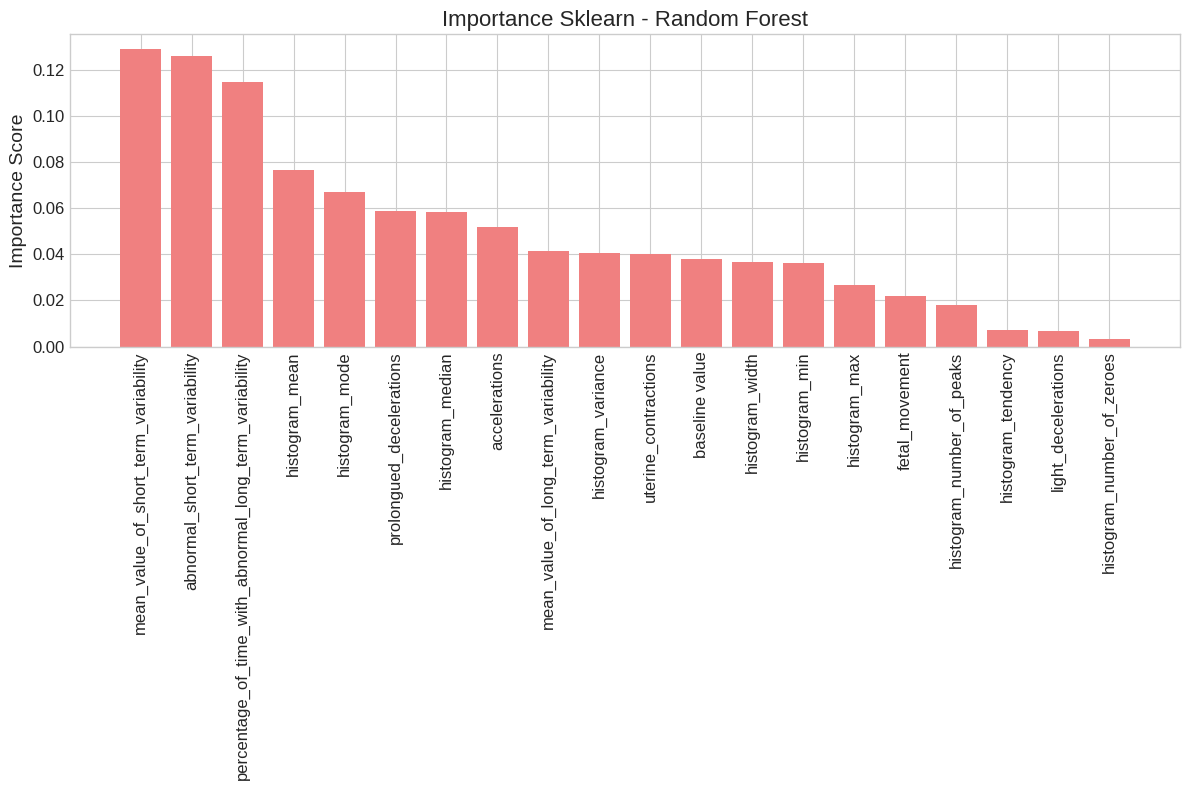


--- Évaluation de Régression Logistique ---
Accuracy: 0.8732
Precision (weighted): 0.8769
Recall (weighted): 0.8732
F1-Score (weighted): 0.8727

Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.95      0.94       332
Pathological       0.88      0.60      0.71        35
     Suspect       0.57      0.63      0.60        59

    accuracy                           0.87       426
   macro avg       0.79      0.72      0.75       426
weighted avg       0.88      0.87      0.87       426



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


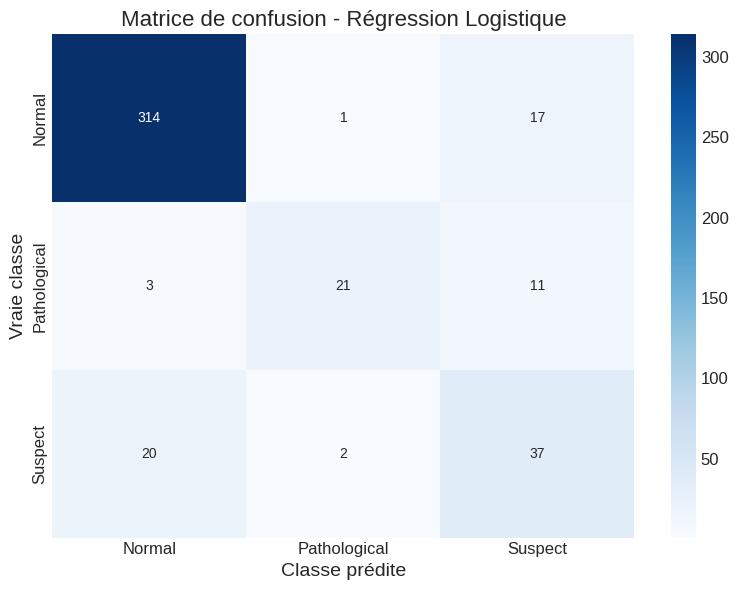

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

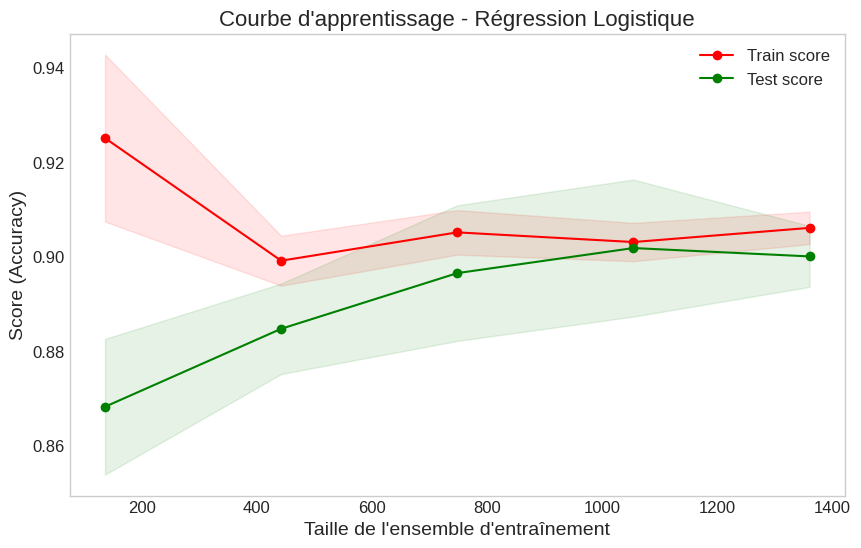

<ipython-input-11-828e36e0c252>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_roc = plt.cm.get_cmap('Set1', n_classes + 2)


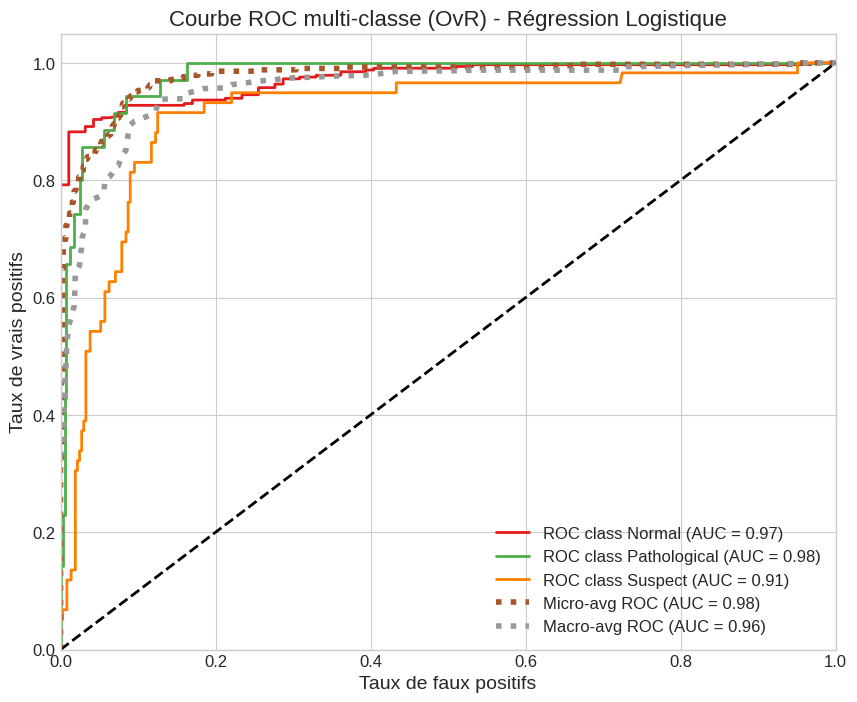

<ipython-input-10-2914cbfe6e4c>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes + 2)


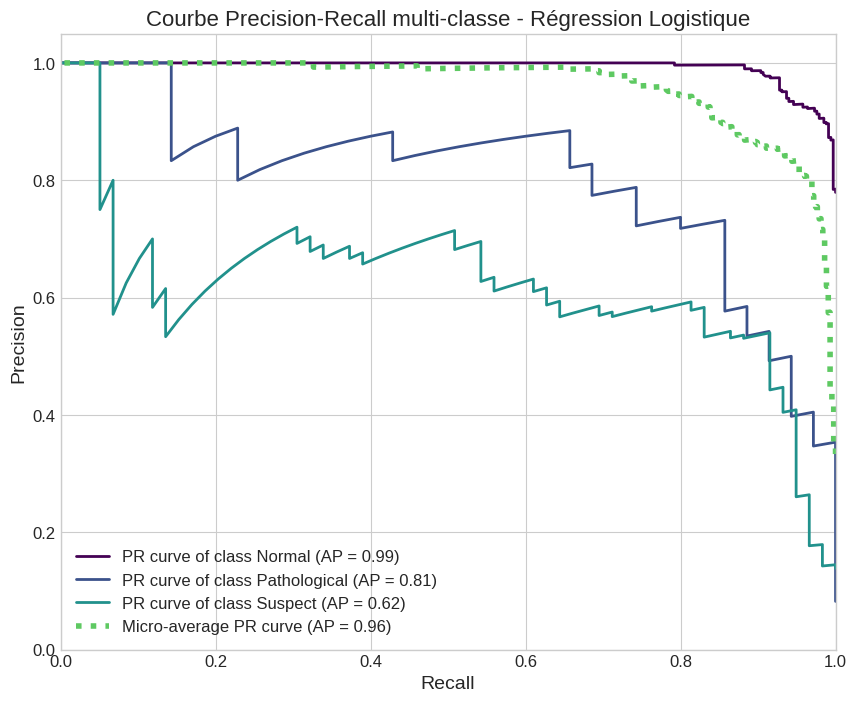

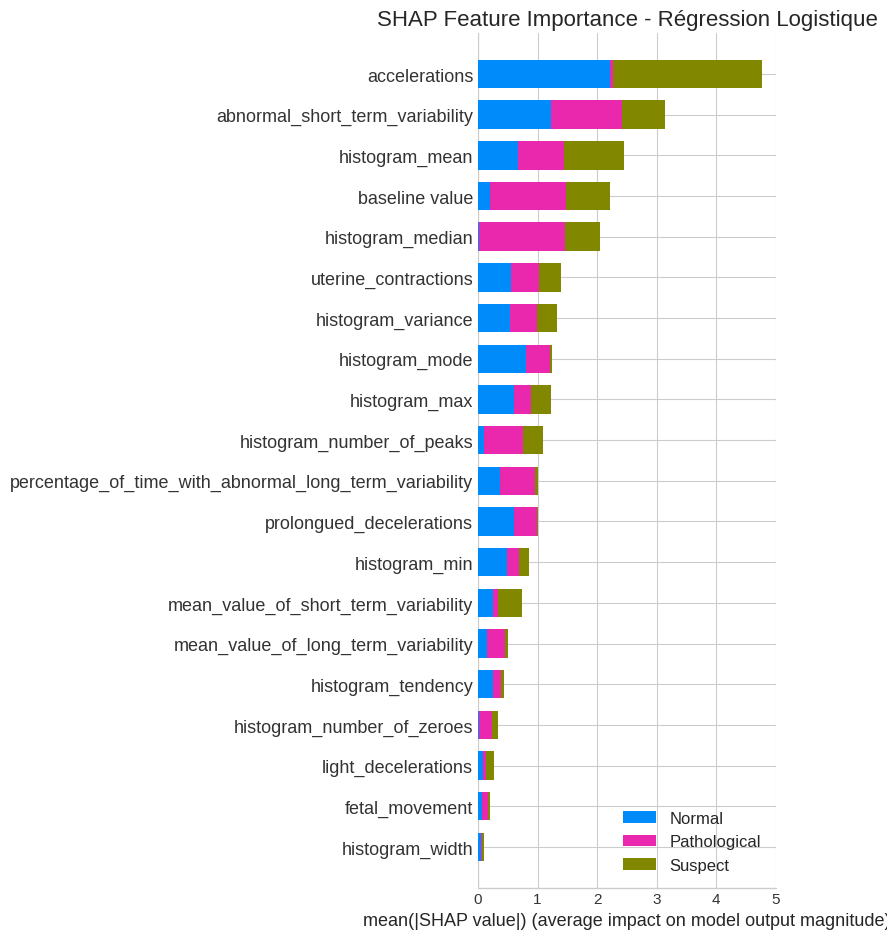

  Could not generate SHAP plots for Régression Logistique: The shape of the shap_values matrix does not match the shape of the provided data matrix.


<Figure size 1000x600 with 0 Axes>

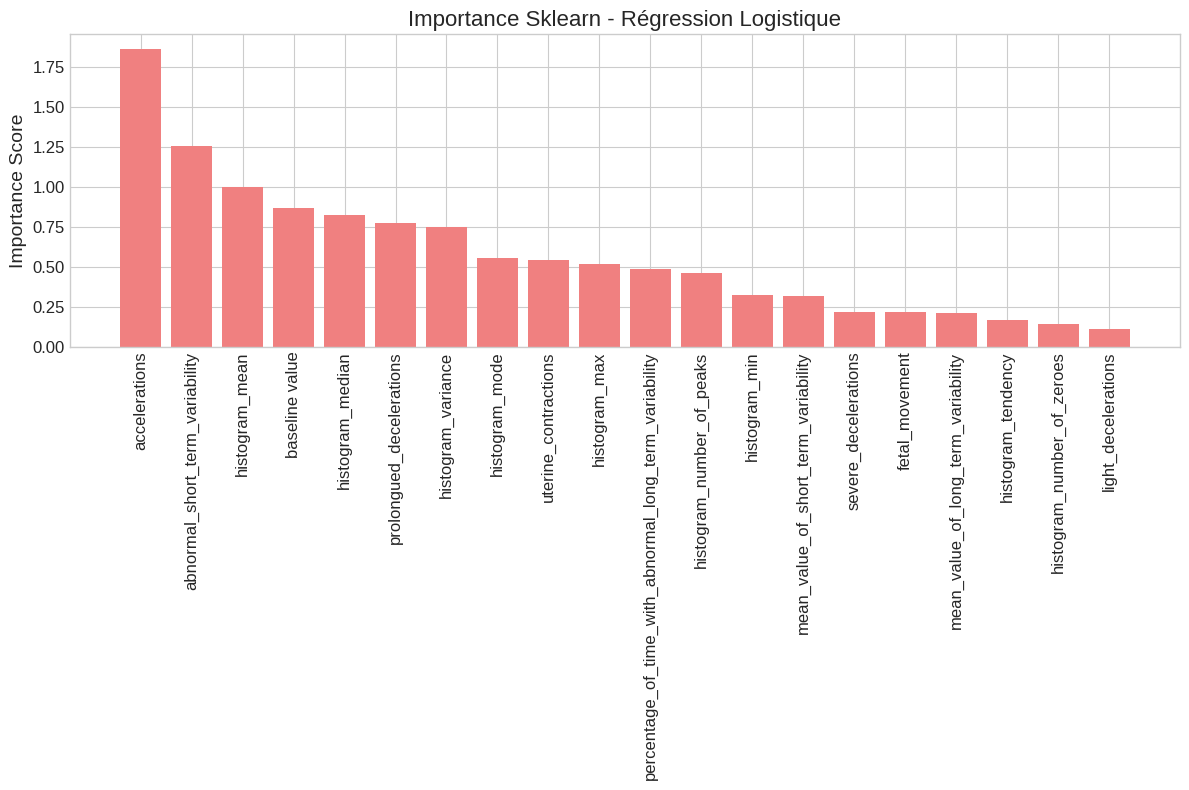


--- Tableau comparatif des modèles ---
                    name  accuracy  precision_weighted  recall_weighted  \
2          Random Forest  0.927230            0.924591         0.927230   
0                    SVM  0.894366            0.888443         0.894366   
3  Régression Logistique  0.873239            0.876880         0.873239   
1                   k-NN  0.870892            0.862338         0.870892   

   f1_weighted  
2     0.924317  
0     0.890065  
3     0.872719  
1     0.862373  


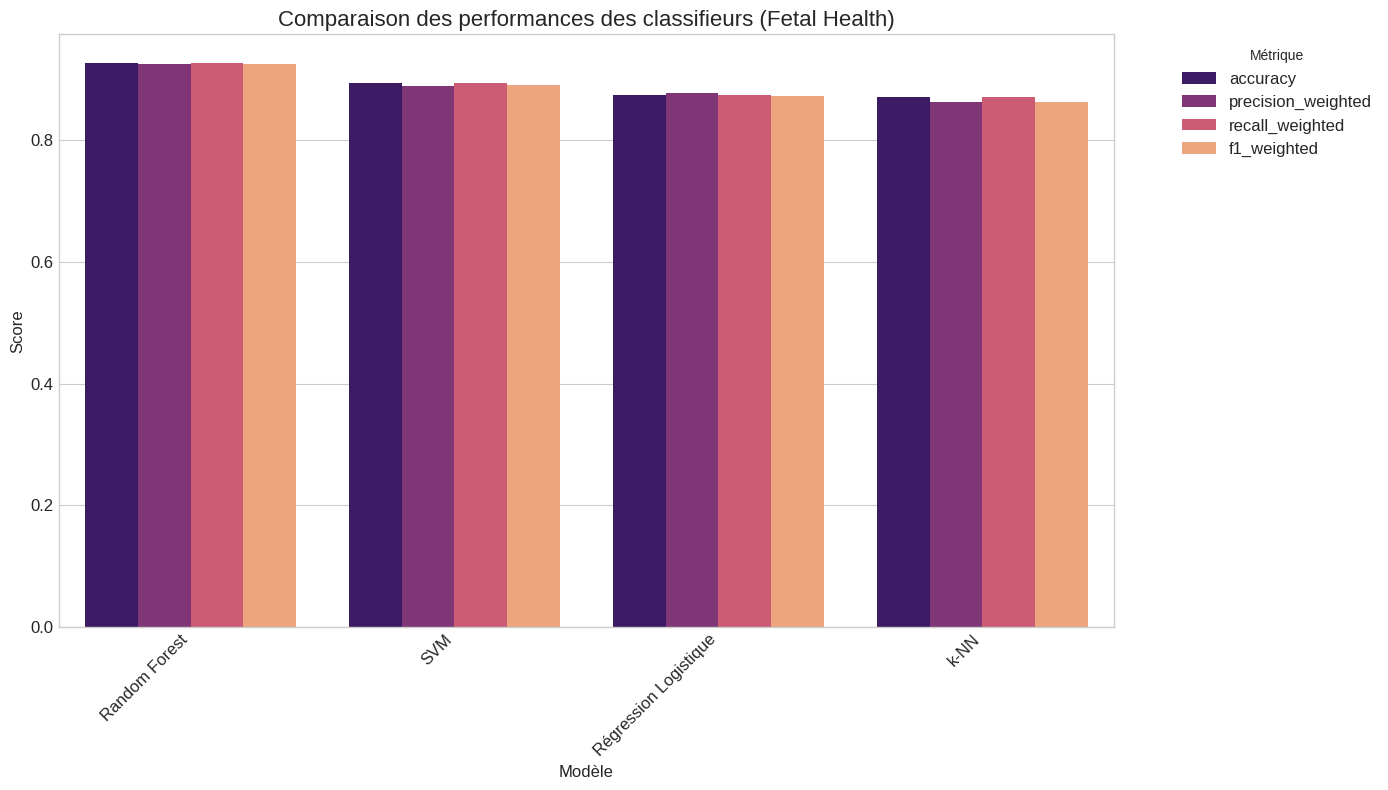

In [12]:
if __name__ == "__main__":
    TRAIN_CSV = 'fetal_train_features.csv'
    TEST_CSV = 'fetal_test_features.csv'

    X_train, y_train, X_test, y_test, feature_names, label_encoder, scaler = load_and_prepare_data(TRAIN_CSV, TEST_CSV)

    feature_names_arr = np.array(feature_names)

    classifiers = [
        (SVC(kernel='rbf', C=1.0, probability=True, random_state=42), 'SVM'),
        (KNeighborsClassifier(n_neighbors=7), 'k-NN'),
        (RandomForestClassifier(n_estimators=100, random_state=42), 'Random Forest'),
        (LogisticRegression(max_iter=2000, random_state=42, solver='liblinear', multi_class='ovr'), 'Régression Logistique')
    ]

    results_list = []
    for clf, name in classifiers:
        result = evaluate_classifier(clf, X_train, y_train, X_test, y_test, name, label_encoder, feature_names_arr, scaler)
        results_list.append(result)

        if name == 'Random Forest' or name == 'Régression Logistique':
             plot_feature_importance_sklearn(feature_names_arr, clf, f"Importance Sklearn - {name}")


    results_df = pd.DataFrame(results_list).sort_values(by='accuracy', ascending=False)
    print("\n--- Tableau comparatif des modèles ---")
    print(results_df)

    plt.figure(figsize=(14, 8))
    metrics_to_plot = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    results_df_plot = results_df.melt(id_vars=['name'], value_vars=metrics_to_plot,
                                    var_name='Métrique', value_name='Score')
    sns.barplot(x='name', y='Score', hue='Métrique', data=results_df_plot, palette='magma')
    plt.title('Comparaison des performances des classifieurs (Fetal Health)', fontsize=16)
    plt.xlabel('Modèle', fontsize=12); plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45, ha='right'); plt.legend(title='Métrique', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(); plt.savefig("model_comparison_fetal.png"); plt.show()

In [13]:
# feature_analysis_fetal.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scipy.stats import f_oneway
from matplotlib.patches import Ellipse


CLASS_NAMES = ['Normal', 'Suspect', 'Pathological']

def load_data(csv_path):
    df = pd.read_csv(csv_path)
    return df

def plot_class_distribution(df, output_dir='.'):
    """Visualizes the distribution of classes."""
    plt.figure(figsize=(8, 6))
    sns.countplot(x='class', data=df, order=CLASS_NAMES, palette="viridis")
    plt.title('Distribution des Classes (État de Santé Foetale)')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'échantillons')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/class_distribution_fetal.png")
    plt.show()


In [14]:
def visualize_feature_distributions(df, feature_cols, plot_type='boxplot', output_dir='.'):
    """
    Visualise la distribution de chaque caractéristique par classe.
    plot_type can be 'boxplot' or 'density'.
    """
    n_features = len(feature_cols)
    cols_per_row = 3
    rows_needed = (n_features + cols_per_row - 1) // cols_per_row

    fig, axes = plt.subplots(rows_needed, cols_per_row, figsize=(cols_per_row * 6, rows_needed * 4))
    axes = axes.flatten()

    for i, feature in enumerate(feature_cols):
        ax = axes[i]
        if plot_type == 'boxplot':
            sns.boxplot(x='class', y=feature, data=df, ax=ax, order=CLASS_NAMES, palette="pastel")
        elif plot_type == 'density':
            for cls_name in CLASS_NAMES:
                sns.kdeplot(df[df['class'] == cls_name][feature], label=cls_name, ax=ax, fill=True, alpha=0.5)
            ax.legend()
        else:
            raise ValueError("plot_type must be 'boxplot' or 'density'")

        groups = [df[df['class'] == cls_name][feature].dropna() for cls_name in CLASS_NAMES]
        groups_for_test = [g for g in groups if len(g) > 1]

        title_str = f'Distribution de {feature}'
        if len(groups_for_test) == len(CLASS_NAMES):
            try:
                f_stat, p_val = f_oneway(*groups_for_test)
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                title_str = f'{feature}\n(ANOVA p={p_val:.2e} {significance})'
            except ValueError as e:
                print(f"Could not perform ANOVA for {feature}: {e}")
        ax.set_title(title_str)
        if plot_type == 'boxplot':
            ax.tick_params(axis='x', rotation=30)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Distributions des caractéristiques par classe ({plot_type.capitalize()})', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/feature_distributions_fetal_{plot_type}.png")
    plt.show()

In [15]:
def generate_correlation_matrix(df, feature_cols, output_dir='.'):
    plt.figure(figsize=(20, 18))
    corr_all = df[feature_cols].corr()
    sns.heatmap(corr_all, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".1f", annot_kws={"size": 7})
    plt.title('Matrice de Corrélation des Caractéristiques - Toutes Classes', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/correlation_matrix_all_fetal.png")
    plt.show()

In [16]:
def plot_pairplot_subset(df, feature_cols, num_features_to_plot=5, output_dir='.'):
    """
    Generates a pairplot for a subset of features.
    Selects features based on ANOVA p-value (lower is better).
    """
    print(f"\nSélection des {num_features_to_plot} caractéristiques les plus significatives pour le Pairplot...")
    feature_p_values = {}
    for feature in feature_cols:
        groups = [df[df['class'] == cls_name][feature].dropna() for cls_name in CLASS_NAMES]
        groups_for_test = [g for g in groups if len(g) > 1]
        if len(groups_for_test) == len(CLASS_NAMES):
            try:
                _, p_val = f_oneway(*groups_for_test)
                feature_p_values[feature] = p_val
            except ValueError:
                feature_p_values[feature] = 1.0
        else:
            feature_p_values[feature] = 1.0

    sorted_features = sorted(feature_p_values, key=feature_p_values.get)
    selected_features = sorted_features[:num_features_to_plot]
    print(f"Caractéristiques sélectionnées pour le Pairplot: {selected_features}")

    if not selected_features:
        print("Aucune caractéristique sélectionnée pour le pairplot. Vérifiez les données.")
        return

    plt.figure()
    pair_plot_df = df[selected_features + ['class']]
    sns.pairplot(pair_plot_df, hue='class', palette={'Normal': 'blue', 'Suspect': 'orange', 'Pathological': 'red'},
                 hue_order=CLASS_NAMES, diag_kind='kde')
    plt.suptitle(f'Pairplot des {num_features_to_plot} Caractéristiques les Plus Discriminantes', y=1.02, fontsize=16)
    plt.savefig(f"{output_dir}/pairplot_subset_fetal.png")
    plt.show()

In [17]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    if x.size != y.size: raise ValueError("x and y must be the same size")
    if x.size < 2 : return
    cov = np.cov(x, y)

    if np.any(np.isnan(cov)) or np.any(np.isinf(cov)) or cov.shape != (2,2):
        return

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    if np.isnan(pearson):
        return

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    if np.isnan(ell_radius_x) or np.isnan(ell_radius_y) or ell_radius_x <= 0 or ell_radius_y <= 0:
        return

    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    if np.isnan(scale_x) or np.isnan(scale_y) or scale_x == 0 or scale_y == 0:
        return

    transf = mtransforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)




In [19]:
def perform_pca_analysis(df, feature_cols, output_dir='.'):

    X = df[feature_cols].values

    le = LabelEncoder()
    if 'class' not in df.columns:
        print("Erreur: La colonne 'class' est manquante dans le DataFrame pour PCA.")
        return

    present_classes = df['class'].unique()
    le.fit(present_classes)


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['class'] = df['class'].values

    plt.figure(figsize=(12, 8))
    palette = {'Normal': 'blue', 'Suspect': 'orange', 'Pathological': 'red'}
    active_palette = {k: palette[k] for k in present_classes if k in palette}

    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class', palette=active_palette,
                    hue_order=[cls for cls in CLASS_NAMES if cls in present_classes],
                    alpha=0.7, s=80)

    for cls_name in present_classes:
        if cls_name in active_palette:
            class_data = pca_df[pca_df['class'] == cls_name]
            if not class_data.empty and len(class_data['PC1'].dropna()) > 1 and len(class_data['PC2'].dropna()) > 1:
                 confidence_ellipse(class_data['PC1'].dropna(), class_data['PC2'].dropna(), plt.gca(), n_std=2.0,
                                   alpha=0.2, facecolor=active_palette[cls_name], edgecolor=active_palette[cls_name],
                                   label='_nolegend_')


    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title('Analyse en Composantes Principales (PCA) des caractéristiques (Fetal Health)', fontsize=16)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    plt.legend(title='Classe')
    plt.savefig(f"{output_dir}/pca_analysis_fetal.png")
    plt.show()

    plt.figure(figsize=(14, 8))
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=feature_cols)
    sns.heatmap(loadings_df, annot=True, cmap='viridis', center=0, fmt=".2f")
    plt.title('Contribution des Caractéristiques aux Composantes Principales (PCA Loadings)', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/pca_feature_contributions_fetal.png")
    plt.show()


Chargement des données d'entraînement pour l'analyse...
Données chargées : (1700, 22) entrées

Visualisation de la distribution des classes...


<ipython-input-13-cc897a32ae9f>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, order=CLASS_NAMES, palette="viridis")


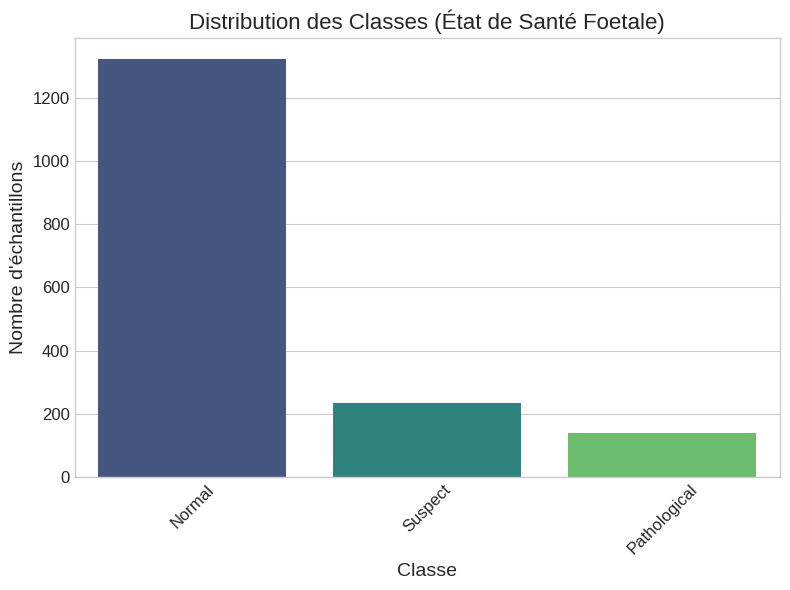


Visualisation des distributions (Boxplots)...


<ipython-input-14-79f1ca4bbecf>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feature, data=df, ax=ax, order=CLASS_NAMES, palette="pastel")
<ipython-input-14-79f1ca4bbecf>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feature, data=df, ax=ax, order=CLASS_NAMES, palette="pastel")
<ipython-input-14-79f1ca4bbecf>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feature, data=df, ax=ax, order=CLASS_NAMES, palette="pastel")
<ipython-input-14-79f1ca4bbecf>:16: FutureWarning: 

Passing `palette` witho

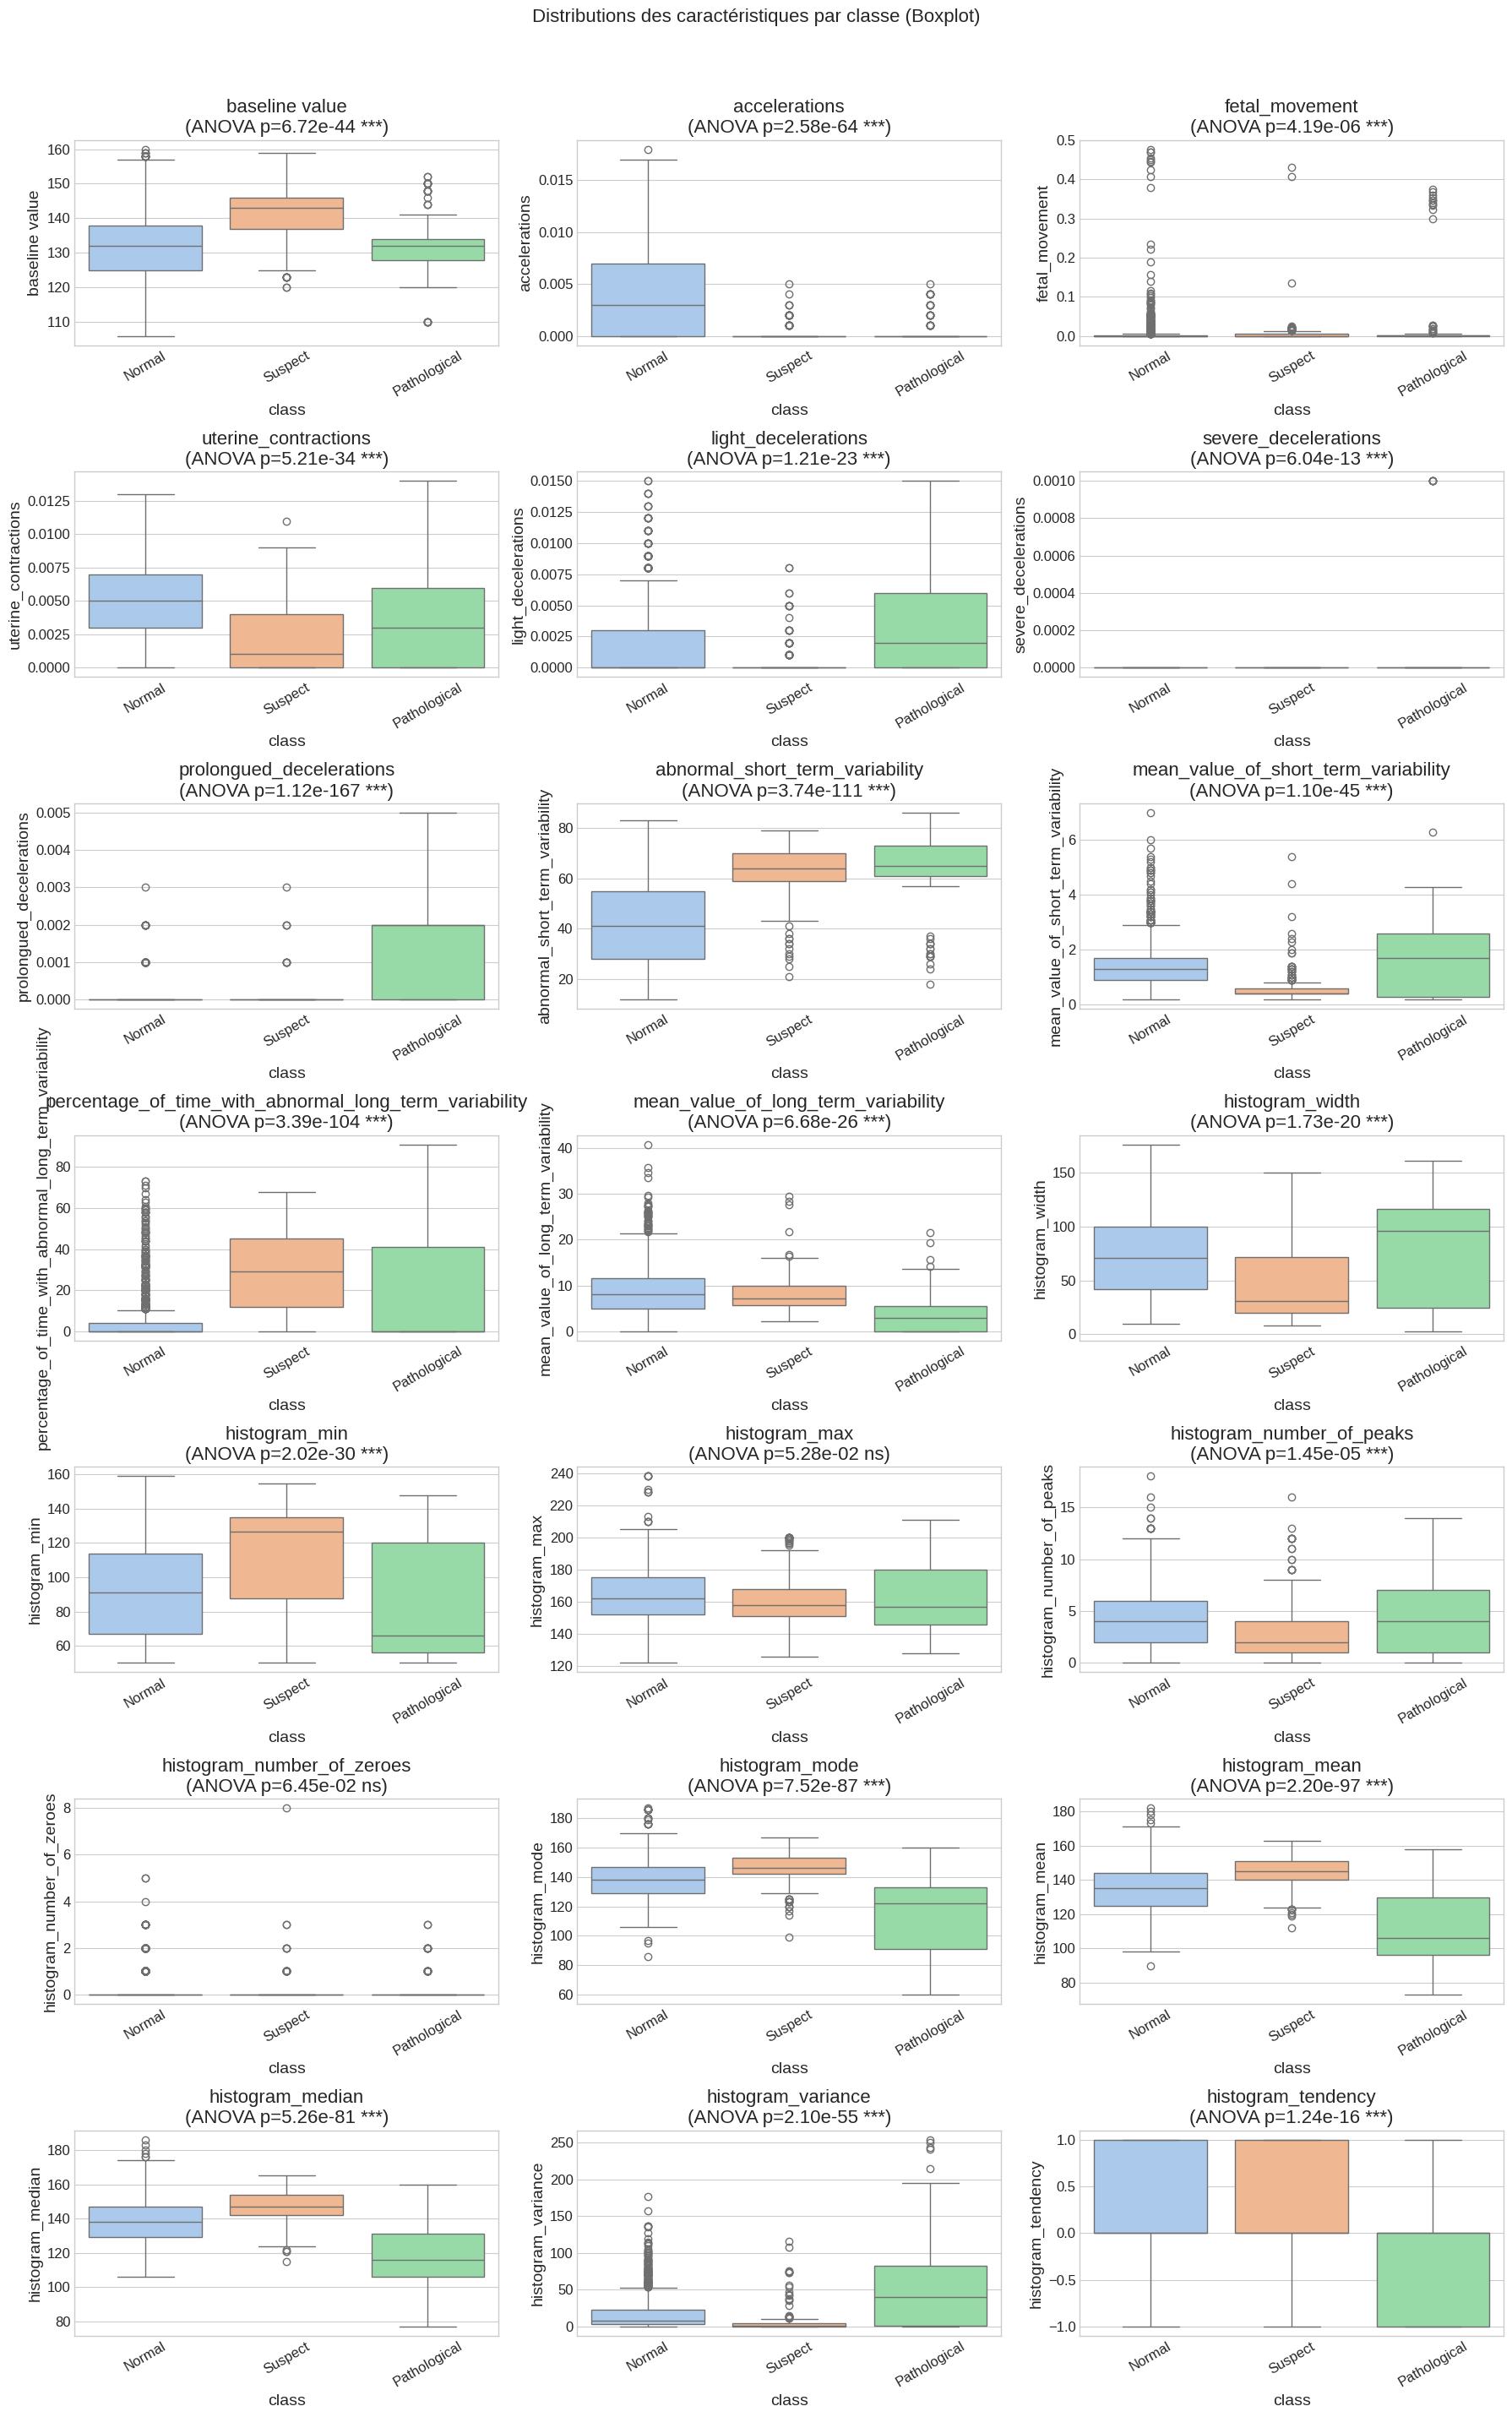


Visualisation des distributions (Density Plots)...


<ipython-input-14-79f1ca4bbecf>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['class'] == cls_name][feature], label=cls_name, ax=ax, fill=True, alpha=0.5)
<ipython-input-14-79f1ca4bbecf>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['class'] == cls_name][feature], label=cls_name, ax=ax, fill=True, alpha=0.5)


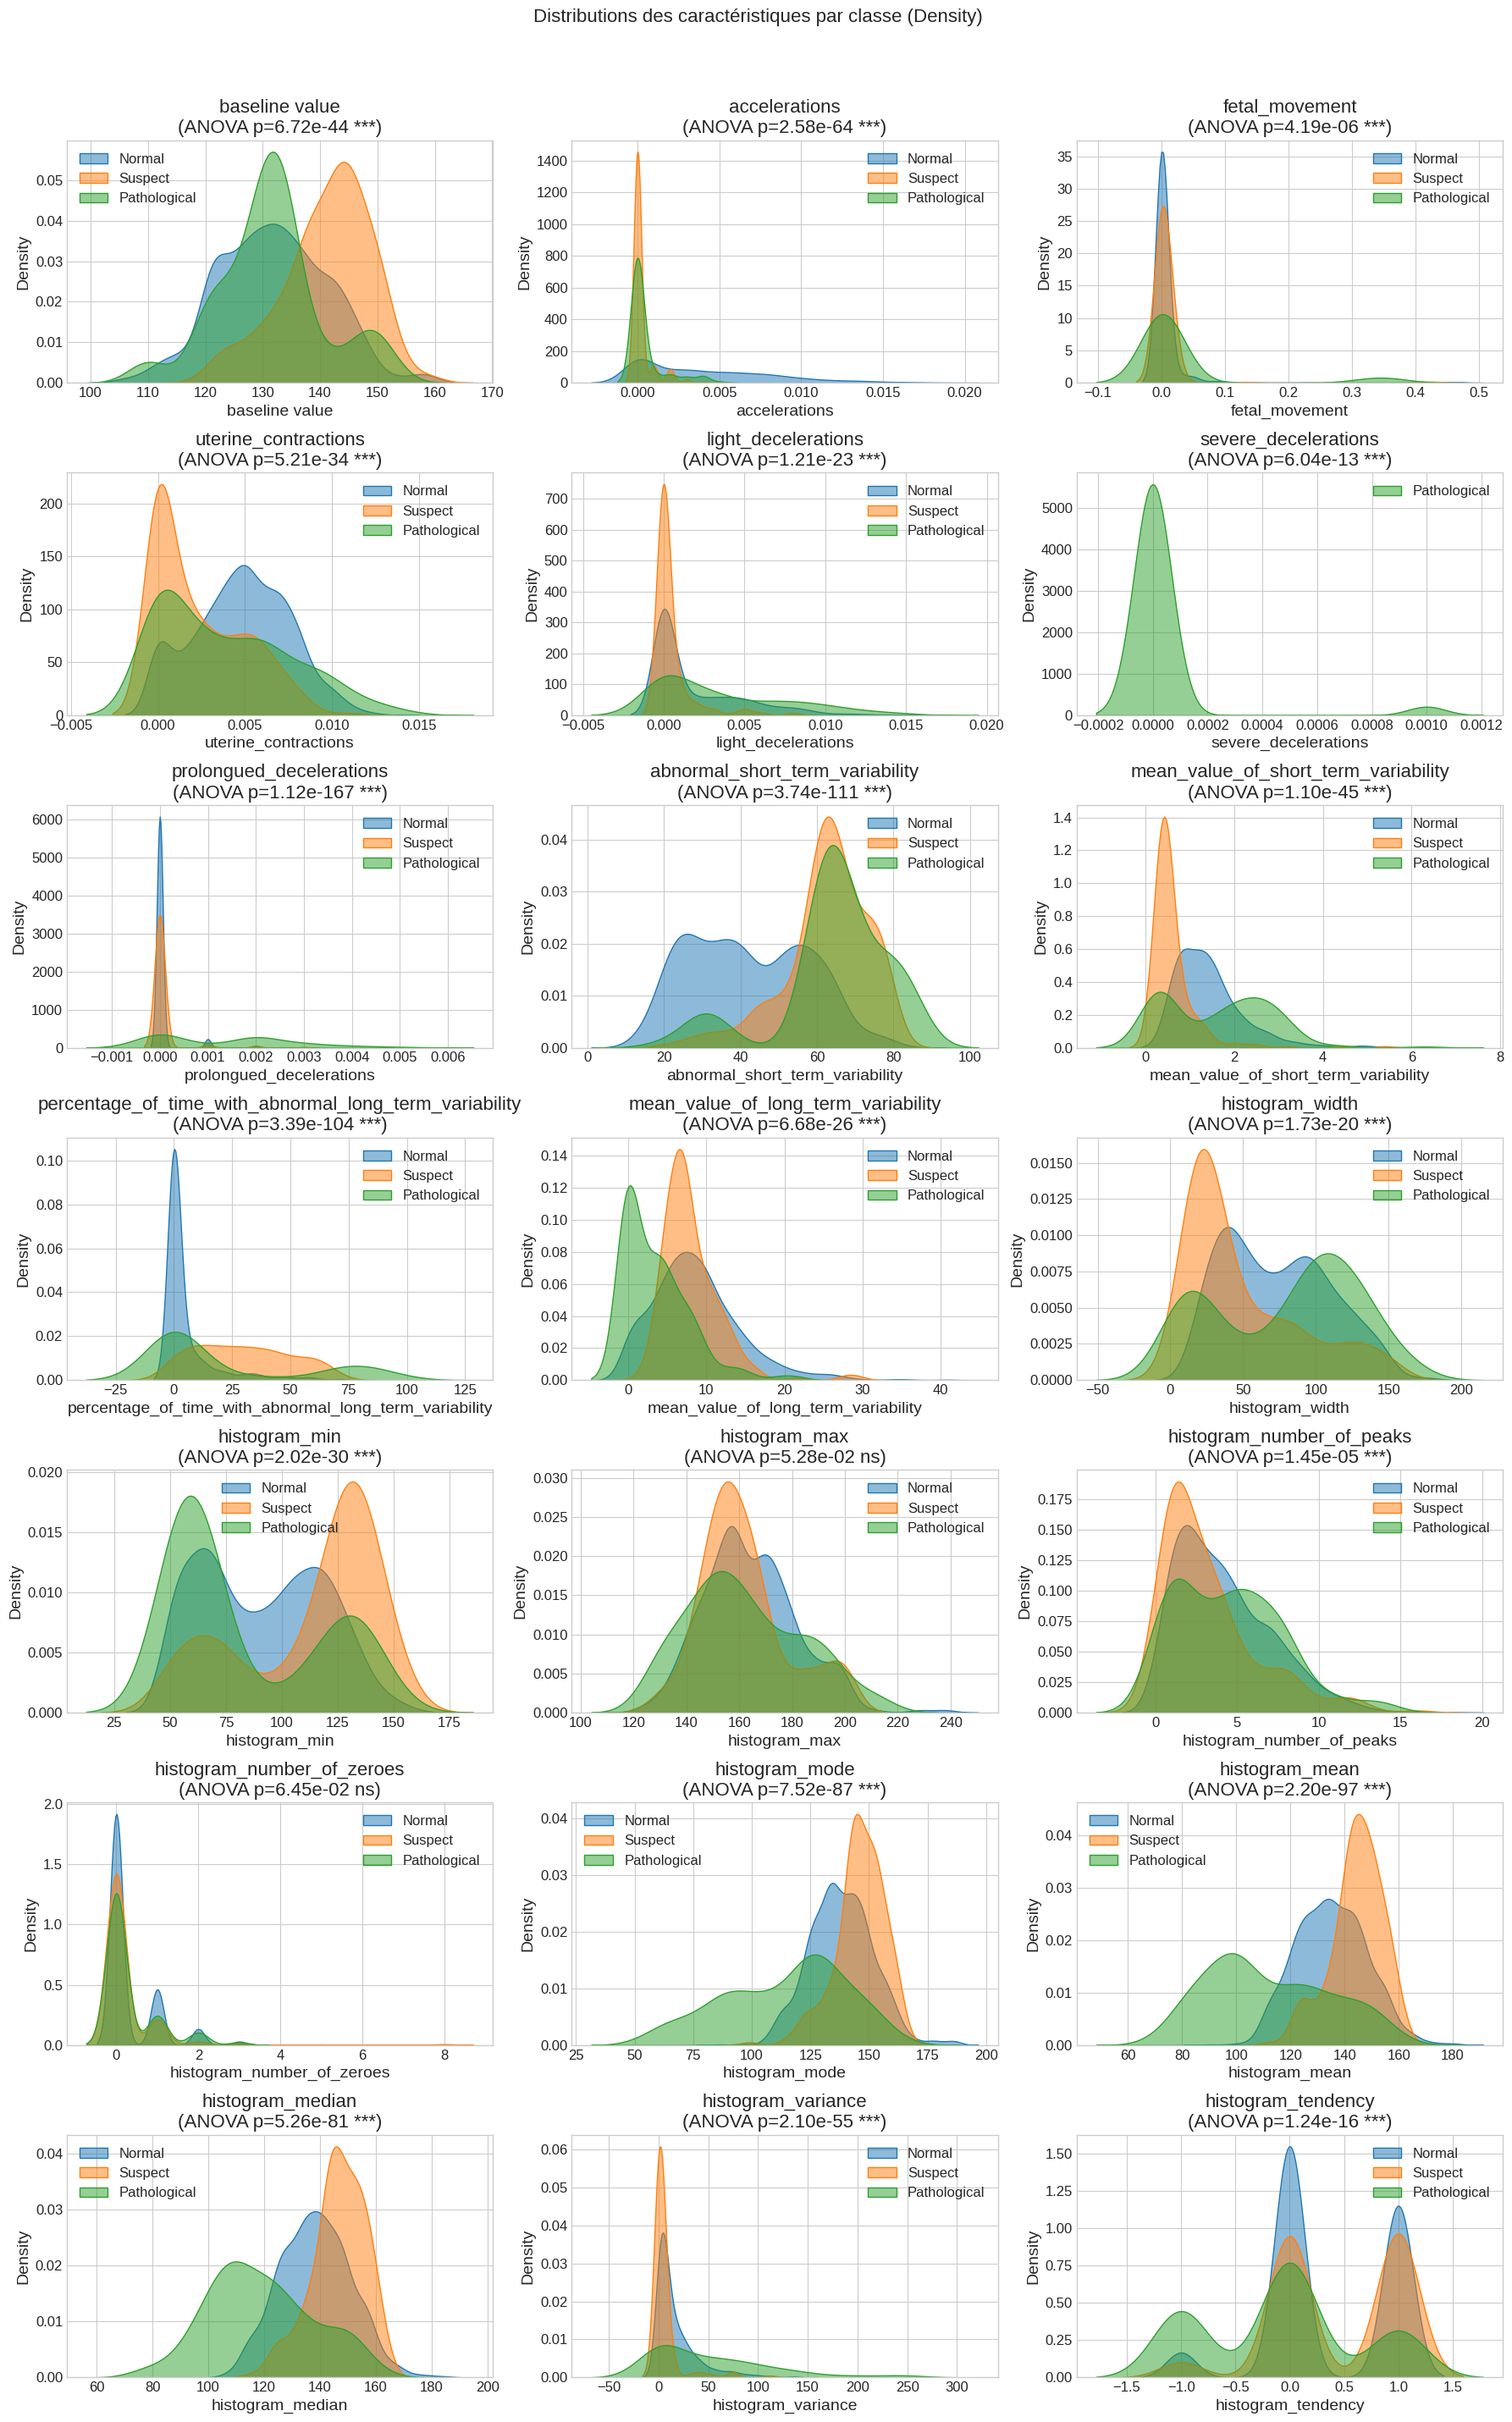


Génération de la matrice de corrélation globale...


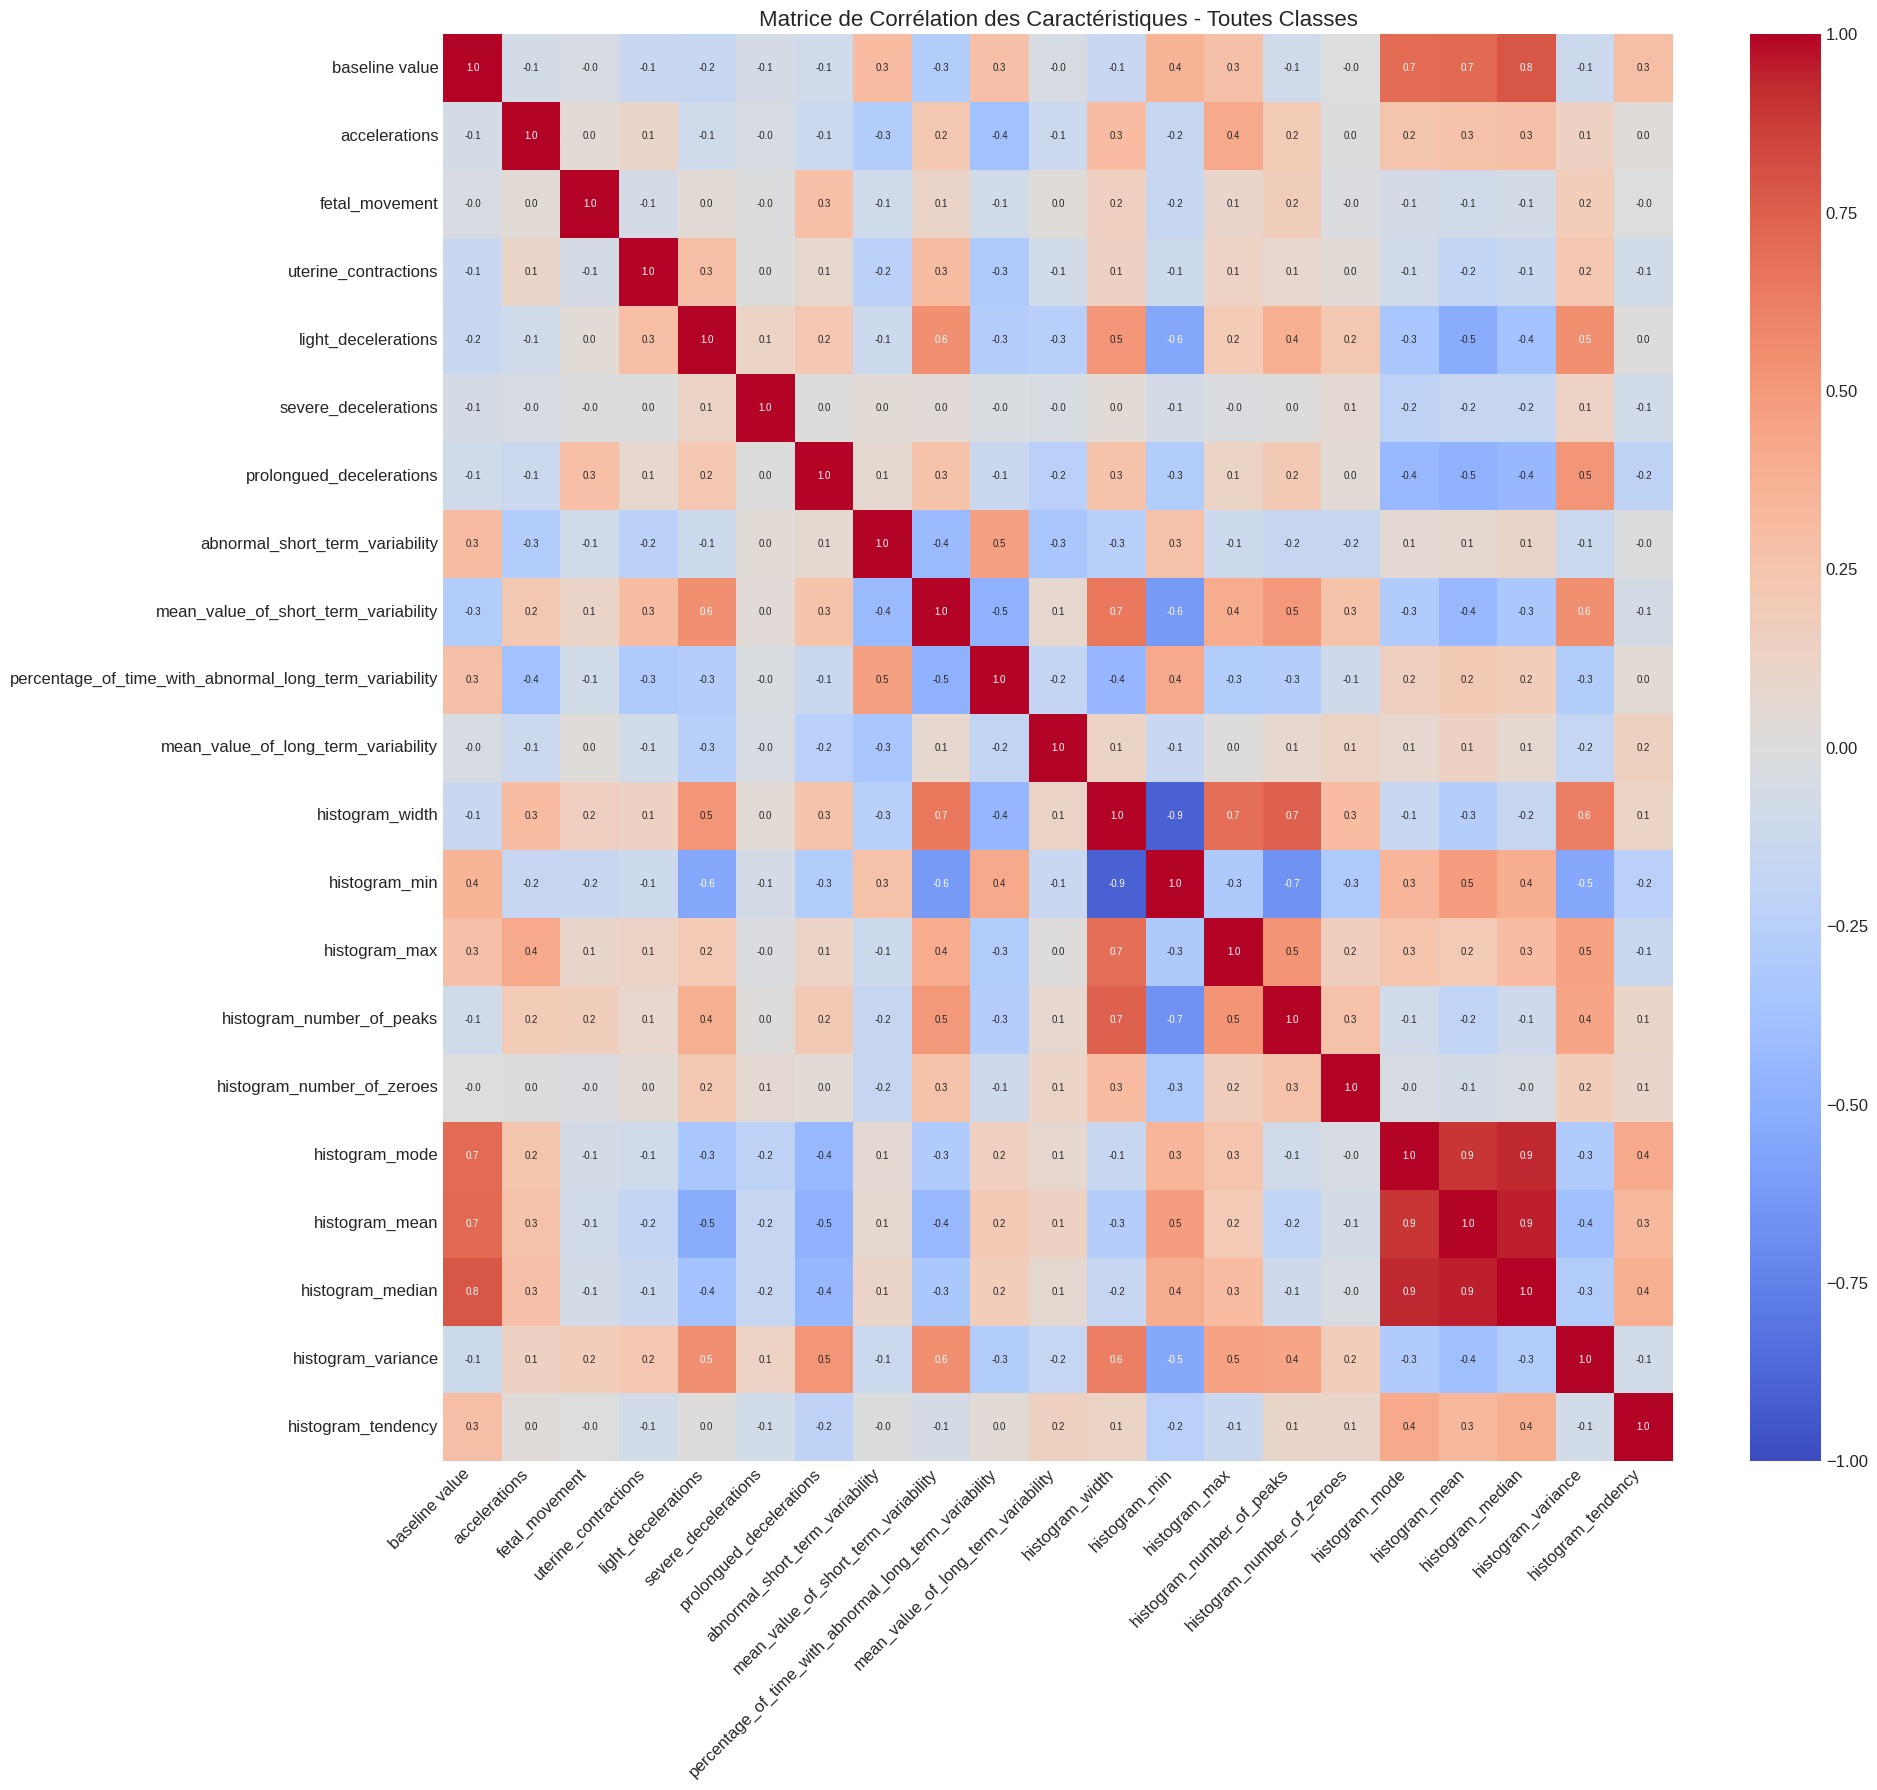


Génération du Pairplot pour un sous-ensemble de caractéristiques...

Sélection des 6 caractéristiques les plus significatives pour le Pairplot...
Caractéristiques sélectionnées pour le Pairplot: ['prolongued_decelerations', 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_mean', 'histogram_mode', 'histogram_median']


<Figure size 1000x600 with 0 Axes>

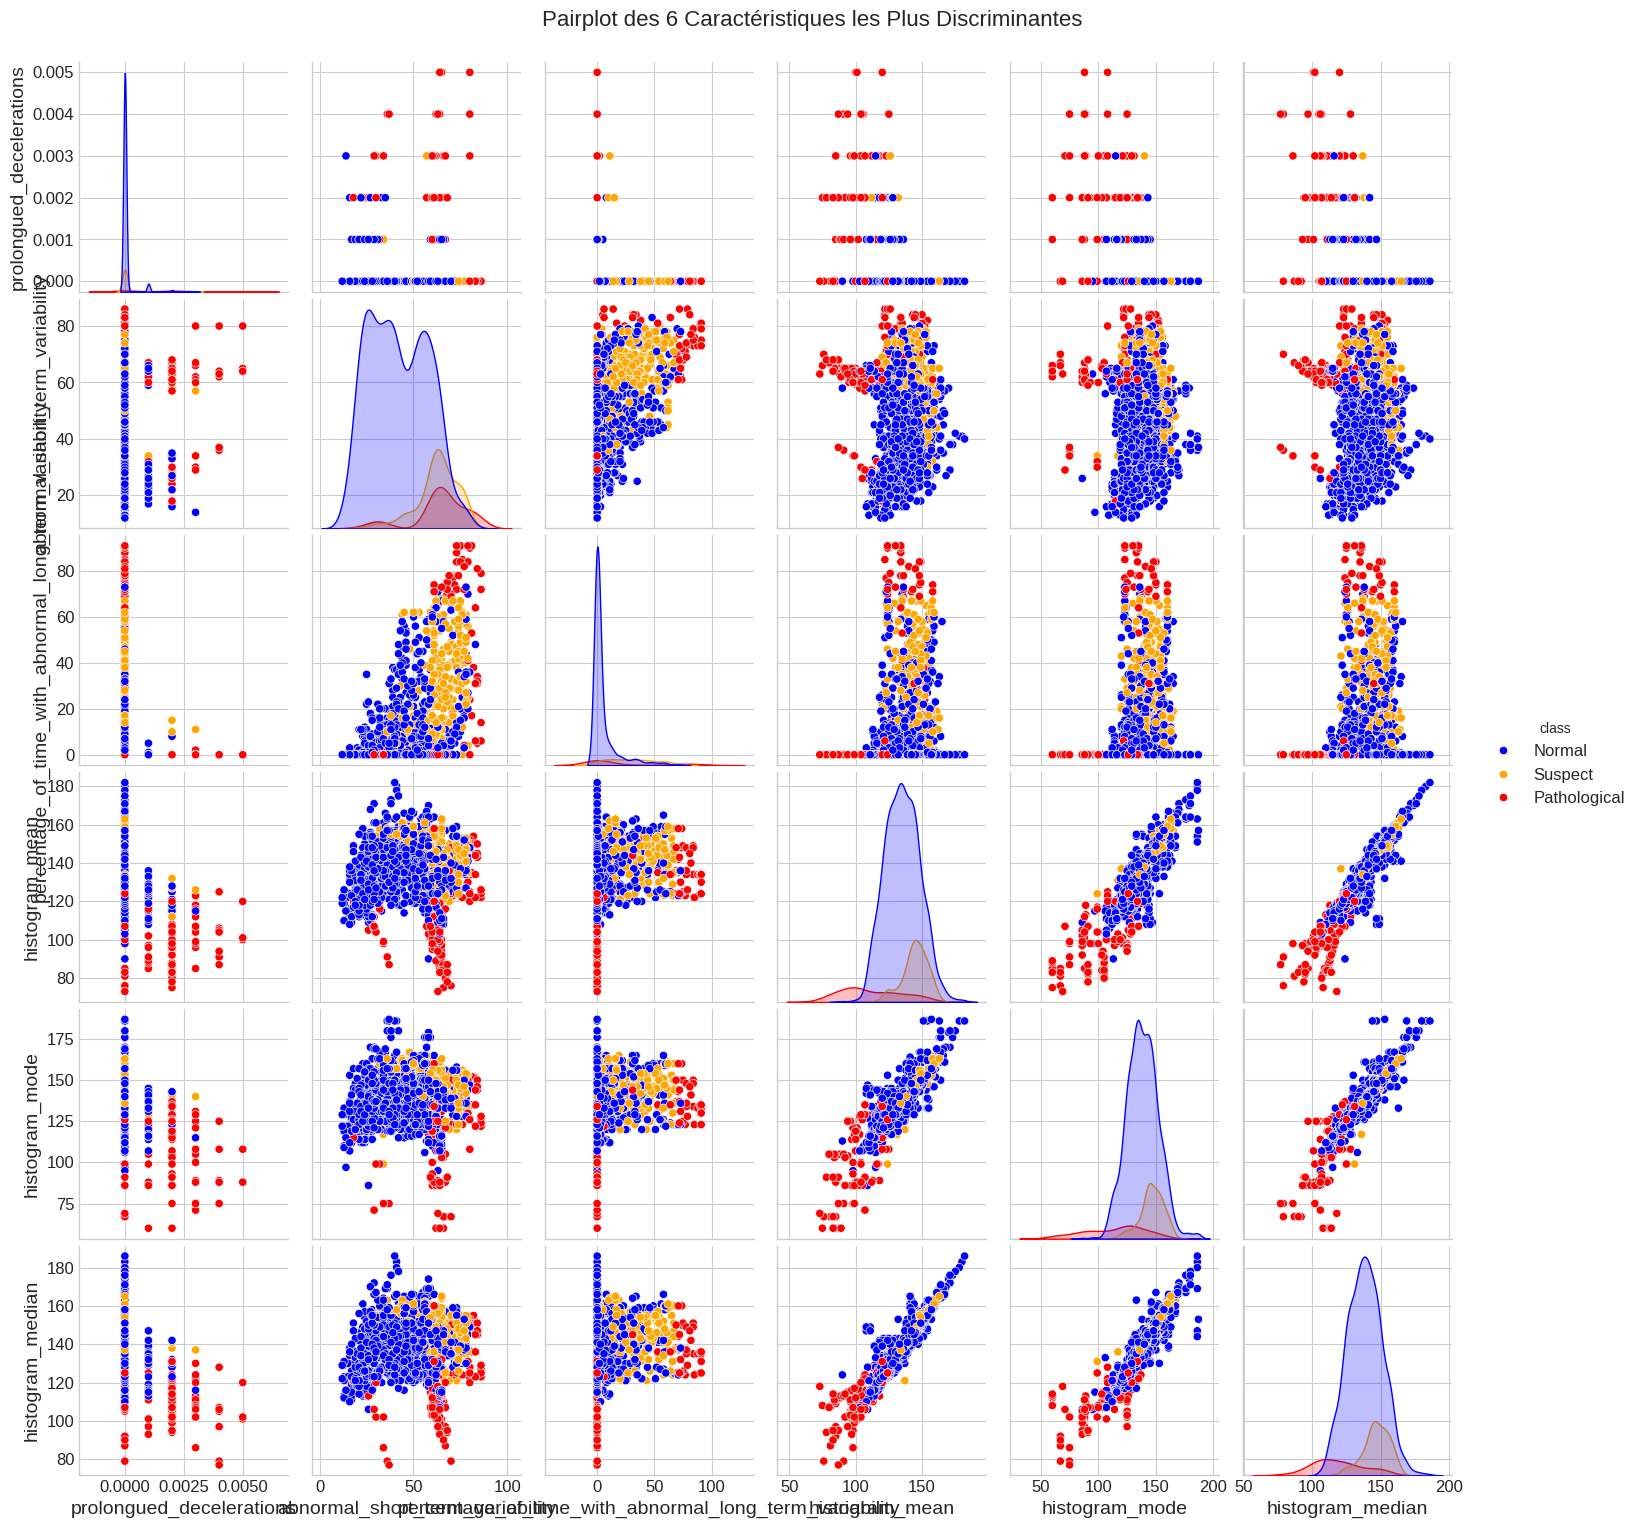


Réalisation de l'analyse en composantes principales (PCA)...


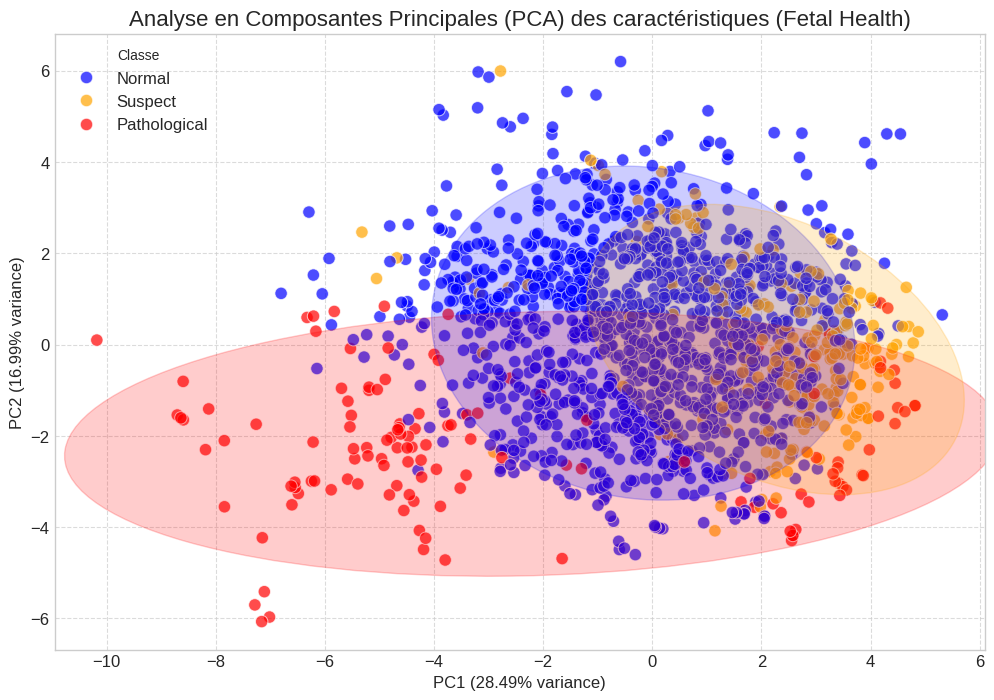

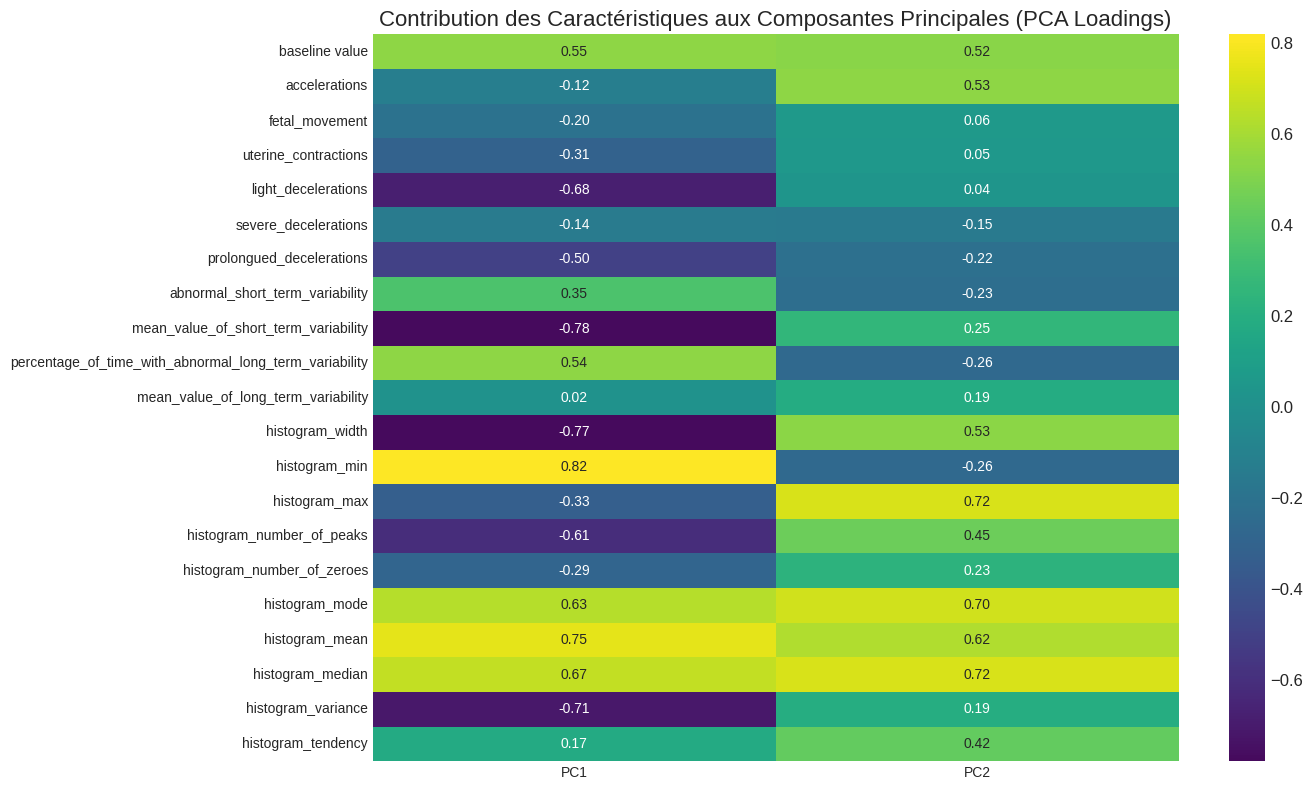


Analyse des caractéristiques terminée!


In [21]:
def main():
    train_csv_path = 'fetal_train_features.csv'
    output_dir = '.'

    print("Chargement des données d'entraînement pour l'analyse...")
    df_train = load_data(train_csv_path)
    if df_train.empty:
        print(f"Impossible de charger {train_csv_path}. Assurez-vous que data_preparation_fetal.py a été exécuté.")
        return

    print(f"Données chargées : {df_train.shape} entrées")

    feature_columns = [col for col in df_train.columns if col != 'class']
    if not feature_columns:
        print("Erreur: Aucune colonne de caractéristiques trouvée. Vérifiez le fichier CSV.")
        return


    print("\nVisualisation de la distribution des classes...")
    plot_class_distribution(df_train, output_dir)

    print("\nVisualisation des distributions (Boxplots)...")
    visualize_feature_distributions(df_train, feature_columns, plot_type='boxplot', output_dir=output_dir)

    print("\nVisualisation des distributions (Density Plots)...")
    visualize_feature_distributions(df_train, feature_columns, plot_type='density', output_dir=output_dir)

    print("\nGénération de la matrice de corrélation globale...")
    generate_correlation_matrix(df_train, feature_columns, output_dir)

    print("\nGénération du Pairplot pour un sous-ensemble de caractéristiques...")
    plot_pairplot_subset(df_train, feature_columns, num_features_to_plot=6, output_dir=output_dir)

    print("\nRéalisation de l'analyse en composantes principales (PCA)...")
    perform_pca_analysis(df_train, feature_columns, output_dir)

    print("\nAnalyse des caractéristiques terminée!")

if __name__ == "__main__":
    main()